<a href="https://colab.research.google.com/github/Gabriela-Alcaide/Analise_de_Redes_Sociais/blob/main/ARS_Detec%C3%A7%C3%A3o_de_Bots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Leitura da Base de Dados e algumas importações.**

In [1]:
!pip install pandas openpyxl
import pandas as pd
from google.colab import files
import pandas as pd

In [2]:
# Fazer upload do arquivo .xlsm
uploaded = files.upload()

# Nome do arquivo (ajuste se necessário)
base_dados = list(uploaded.keys())[0]

# Ler o arquivo .xlsm
base = pd.read_excel(base_dados, engine='openpyxl', sheet_name='dados')

Saving bluesky.xlsm to bluesky.xlsm


# **Adaptar para formato numérico**

In [3]:
# Handle.

from sklearn.preprocessing import LabelEncoder

In [5]:
label_encoder = LabelEncoder()

In [6]:
base['handle'] = label_encoder.fit_transform(base['handle'])

In [7]:
# Variáveis binárias.

In [8]:
# displayName.
for i, d in enumerate(base['displayName']):
  if pd.isna(d):
    base.at[i, 'displayName'] = 0
  else:
    base.at[i, 'displayName'] = 1

In [9]:
# imagem_perfil
base['imagem_perfil'] = base['imagem_perfil'].map({'Sim': 1, 'Nao': 0})

# imagem_banner
base['imagem_banner'] = base['imagem_banner'].map({'Sim': 1, 'Nao': 0})

# tirar data_criacao
base = base.drop('data_criacao', axis=1)

In [10]:
# sentimento_mais_frequente
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
sentimento_encoded = encoder.fit_transform(base[['sentimento_mais_frequente']])
df_encoded = pd.DataFrame(sentimento_encoded, columns=encoder.get_feature_names_out(['sentimento_mais_frequente']))
base = base.drop('sentimento_mais_frequente', axis=1)
base = pd.concat([base, df_encoded], axis=1)

In [11]:
# classificacao
base['classificacao'] = base['classificacao'].map({'bot': 1, 'humano': 0})

# **Balanceamento do Conjunto de Treinamento**

In [12]:
num_contas = len(base)

In [13]:
num_contas

203

In [14]:
# Linhas de usuários bots.
bots = base[base["classificacao"] == 1]

# Contando o número de bots
num_bots = len(bots)

In [15]:
# % de bots.
prop_bots = (num_bots / num_contas) * 100

print(prop_bots)

28.57142857142857


In [16]:
# Lista de usuários humanos.
humanos = base[base["classificacao"] == 0]

# Contando o número de bots
num_humanos = len(humanos)

In [17]:
# % de humanos.
prop_humanos = 100 - prop_bots

print(prop_humanos)

71.42857142857143


Percebe-se que o Conjunto é desbalanceado: há 30% bots e 70% humanos.

In [18]:
# Filtrar 70% dos bots, para compôr o conjunto de treinamento.
bots_treinamento = bots.sample(frac=0.7, random_state=0)

In [19]:
len(bots_treinamento)

41

In [20]:
# Filtrar a mesma quantidade de humanos, para complementar o conjunto de treinamento.
humanos_treinamento = humanos.sample(n=41, random_state=0)

In [21]:
# Conjunto de treinamento.
treinamento = pd.concat([bots_treinamento, humanos_treinamento], axis=0, ignore_index=True)

In [22]:
# Montar o conjunto de teste e validação com os usuários fora do treinamento.
todos_handles = set(base['handle'])
handles_treinamento = set(treinamento['handle'])

handles_teste = todos_handles - handles_treinamento

teste = base[base['handle'].isin(handles_teste)]

# **Executar Árvore de Decisão.**

In [23]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [24]:
# Separar o conjunto de treinamento entre variáveis X e Y.
x_treino = treinamento.drop('classificacao', axis=1)
y_treino = treinamento['classificacao']

In [25]:
# Separar o conjunto de teste entre variáveis X e Y.
x_teste = teste.drop('classificacao', axis=1)
y_teste = teste['classificacao']

In [26]:
!pip install scikit-learn

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

Modelo 01: Simples

In [28]:
# Criar modelo.
model = DecisionTreeClassifier(random_state=0)

In [29]:
# Treinar modelo.
model.fit(x_treino, y_treino)

DecisionTreeClassifier(random_state=0)

In [30]:
# Fazer o modelo prever com base em x_teste.
y_pred = model.predict(x_teste)

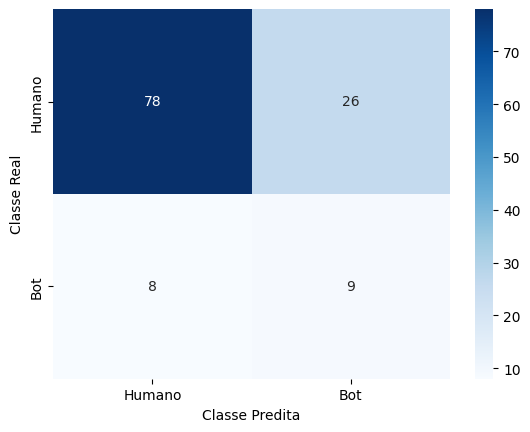

In [31]:
# Matriz de confusão.
from sklearn.metrics import confusion_matrix

# Matriz de confusão
cm = confusion_matrix(y_teste, y_pred)

import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Humano', 'Bot'], yticklabels=['Humano', 'Bot'])
plt.ylabel('Classe Real')
plt.xlabel('Classe Predita')
plt.show()

In [32]:
# Calcular acurácia.
accuracy = accuracy_score(y_teste, y_pred)
accuracy

0.71900826446281

In [33]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calcular precisão, recall e F1-score
precision = precision_score(y_teste, y_pred)
recall = recall_score(y_teste, y_pred)
f1 = f1_score(y_teste, y_pred)

# capacidade do modelo de não classificar erroneamente exemplos humanos como bots.
# classifica muitos humanos como bots.
print(f'Precisão: {precision:.2f}')

# capacidade do modelo de encontrar todos os bots.
print(f'Recall: {recall:.2f}')

# o mais útil.
print(f'F1-Score: {f1:.2f}')

Precisão: 0.26
Recall: 0.53
F1-Score: 0.35


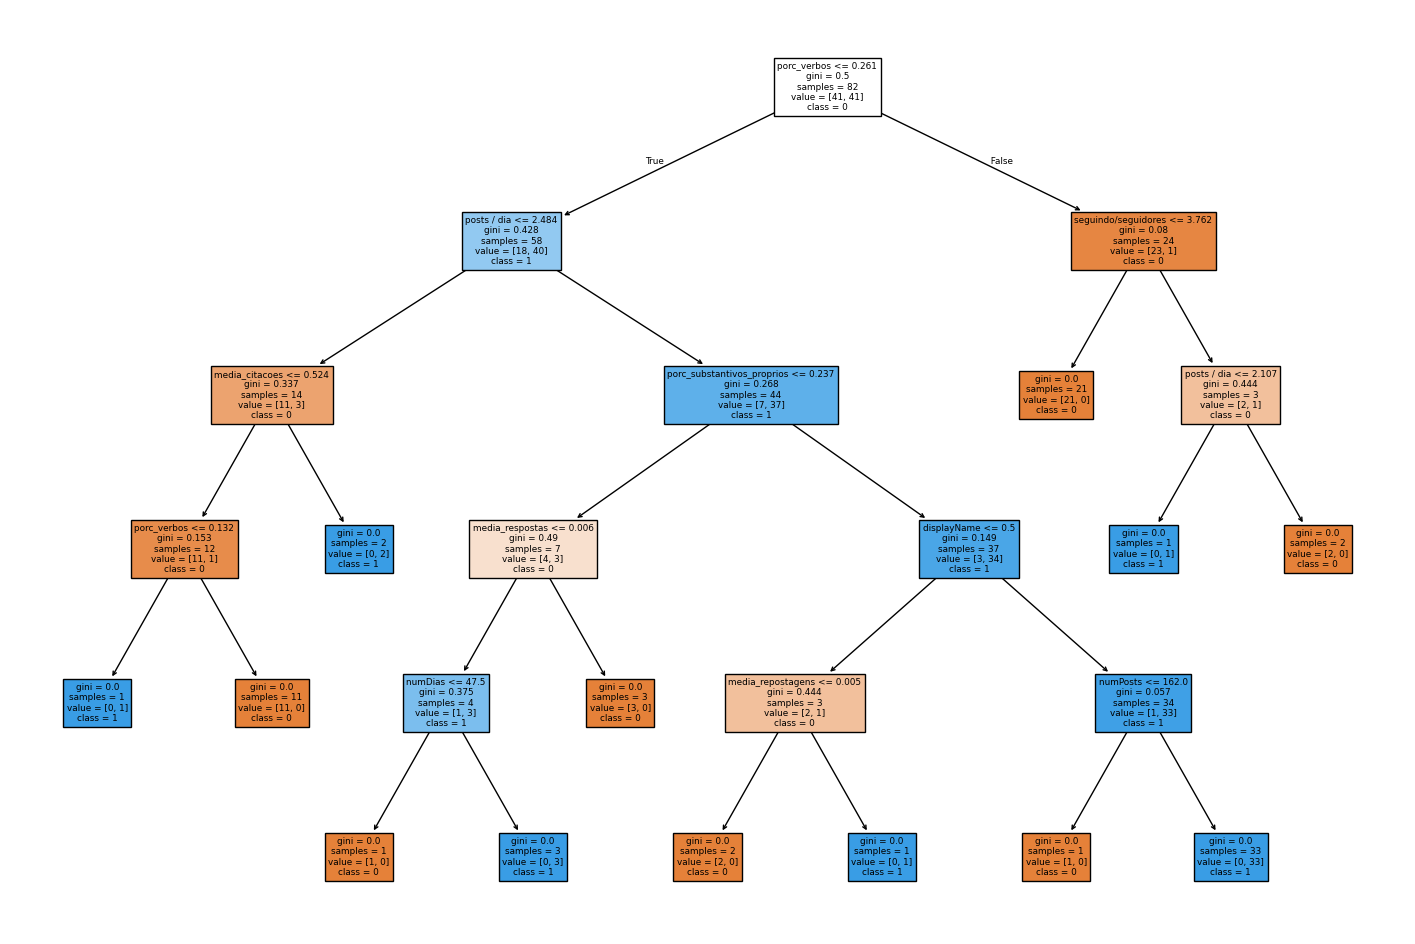

In [34]:
# Visualizar a árvore.
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Plotar a árvore de decisão
plt.figure(figsize=(18, 12))
plot_tree(model, filled=True, feature_names=['handle', 'displayName', 'imagem_perfil', 'imagem_banner', 'numPosts', 'numDias', 'posts / dia', 'seguidores', 'seguindo', 'seguindo/seguidores', 'porc_substantivos_proprios', 'porc_substantivos_comuns', 'porc_verbos', 'porc_adjetivos', 'media_respostas', 'media_repostagens', 'media_curtidas', 'media_citacoes', 'sentimento_mais_frequente_NEGATIVE', 'sentimento_mais_frequente_POSITIVE'], class_names=['0', '1'])
plt.show()

Testando possibilidades.

In [35]:
from itertools import product

In [36]:
arvores = {}

possibilidades = {
    "altura": [1, 2, 3, 4, 5],
}

combinacoes = list(product(*possibilidades.values()))

for c in combinacoes:
  # Criar modelo.
  model = DecisionTreeClassifier(random_state=0, max_depth=c[0])
  # Treinar modelo.
  model.fit(x_treino, y_treino)
  # Fazer o modelo prever com base em x_teste.
  y_pred = model.predict(x_teste)
  # Calcular acurácia.
  accuracy = accuracy_score(y_teste, y_pred)
  # capacidade do modelo de não classificar erroneamente exemplos humanos como bots.
  # classifica muitos humanos como bots.
  precision = precision_score(y_teste, y_pred)
  # capacidade do modelo de encontrar todos os bots.
  recall = recall_score(y_teste, y_pred)
  # o mais útil.
  f1 = f1_score(y_teste, y_pred)
  arvores[f"Altura: {c[0]}"] = f"Acurácia: {accuracy:.2f}; precisão: {precision:.2f}; recall: {recall:.2f}; f1: {f1:.2f}"

In [37]:
arvores

{'Altura: 1': 'Acurácia: 0.60; precisão: 0.25; recall: 0.88; f1: 0.38',
 'Altura: 2': 'Acurácia: 0.69; precisão: 0.26; recall: 0.65; f1: 0.37',
 'Altura: 3': 'Acurácia: 0.70; precisão: 0.26; recall: 0.59; f1: 0.36',
 'Altura: 4': 'Acurácia: 0.69; precisão: 0.25; recall: 0.59; f1: 0.35',
 'Altura: 5': 'Acurácia: 0.72; precisão: 0.26; recall: 0.53; f1: 0.35'}

# **Random Forest.**

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [39]:
# Criar modelo.
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

In [40]:
# Treinar o modelo
rf_model.fit(x_treino, y_treino)

RandomForestClassifier(random_state=42)

In [41]:
# Fazer previsões
y_pred = rf_model.predict(x_teste)

In [42]:
# Avaliar o desempenho
print("Acurácia:", accuracy_score(y_teste, y_pred))
print("\nMatriz de Confusão:\n", confusion_matrix(y_teste, y_pred))
print("\nRelatório de Classificação:\n", classification_report(y_teste, y_pred))

# Precisão: 86%
# Recall: 77%
# F1-score: 80%

Acurácia: 0.768595041322314

Matriz de Confusão:
 [[81 23]
 [ 5 12]]

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.94      0.78      0.85       104
           1       0.34      0.71      0.46        17

    accuracy                           0.77       121
   macro avg       0.64      0.74      0.66       121
weighted avg       0.86      0.77      0.80       121



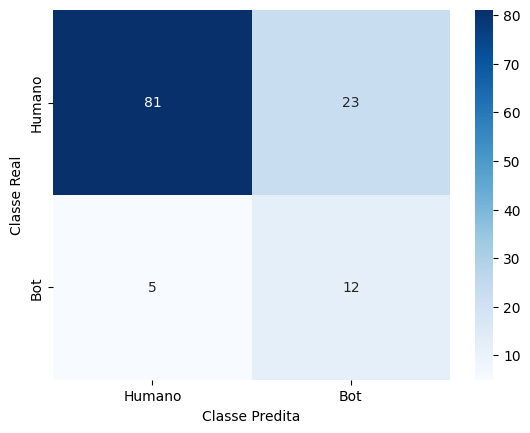

In [43]:
# Matriz de confusão.
from sklearn.metrics import confusion_matrix

# Matriz de confusão
cm = confusion_matrix(y_teste, y_pred)

import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Humano', 'Bot'], yticklabels=['Humano', 'Bot'])
plt.ylabel('Classe Real')
plt.xlabel('Classe Predita')
plt.show()

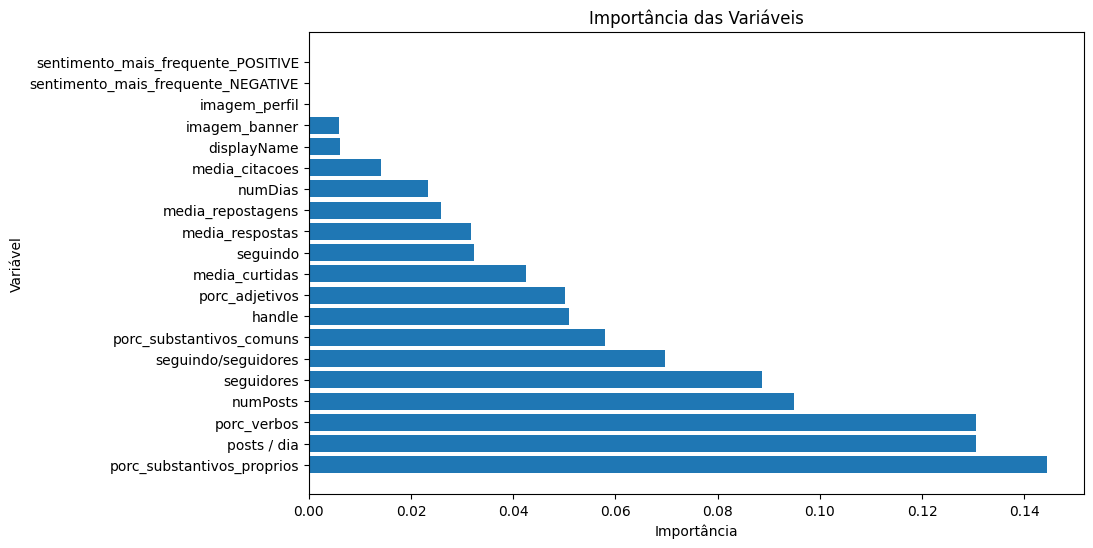

In [44]:
# Importância das Variáveis

importances = rf_model.feature_importances_
feature_names = x_treino.columns
df_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# Visualização
plt.figure(figsize=(10, 6))
plt.barh(df_importances['Feature'], df_importances['Importance'])
plt.xlabel('Importância')
plt.ylabel('Variável')
plt.title('Importância das Variáveis')
plt.show()


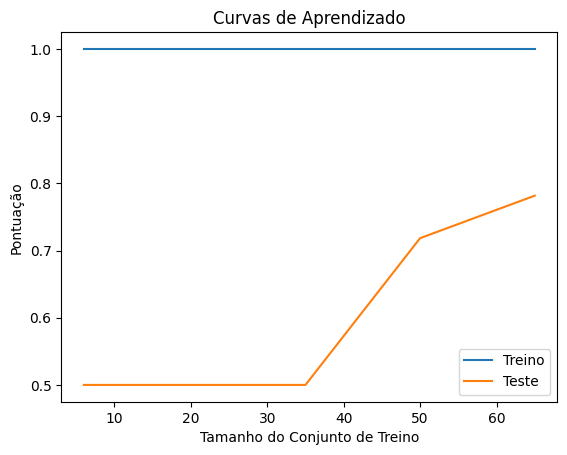

In [45]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(rf_model, x_treino, y_treino, cv=5)
plt.plot(train_sizes, train_scores.mean(axis=1), label='Treino')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Teste')
plt.legend()
plt.xlabel('Tamanho do Conjunto de Treino')
plt.ylabel('Pontuação')
plt.title('Curvas de Aprendizado')
plt.show()


# **Regressão Logística.**

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [47]:
# Criando o Modelo.
model = LogisticRegression()

In [48]:
# Treinando o modelo.
model.fit(x_treino, y_treino)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [49]:
# Fazer previsões.
y_pred = model.predict(x_teste)

In [50]:
# Avaliar o modelo
print("Acurácia:", accuracy_score(y_teste, y_pred))
print("Relatório de Classificação:\n", classification_report(y_teste, y_pred))

# precisão: 78%
# recall: 69%
# f1-score: 75%

Acurácia: 0.6859504132231405
Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.88      0.74      0.80       104
           1       0.18      0.35      0.24        17

    accuracy                           0.69       121
   macro avg       0.53      0.55      0.52       121
weighted avg       0.78      0.69      0.72       121



In [51]:
# import pandas as pd
coef = pd.DataFrame({
    "Atributo": x_treino.columns,
    "Coeficiente": model.coef_[0]
}).sort_values(by="Coeficiente", ascending=False)
print(coef)

                              Atributo  Coeficiente
10          porc_substantivos_proprios     0.003564
1                          displayName     0.002477
4                             numPosts     0.001780
17                      media_citacoes     0.001275
7                           seguidores     0.000043
8                             seguindo     0.000027
19  sentimento_mais_frequente_POSITIVE     0.000000
2                        imagem_perfil    -0.000149
18  sentimento_mais_frequente_NEGATIVE    -0.000149
13                      porc_adjetivos    -0.000427
14                     media_respostas    -0.000510
11            porc_substantivos_comuns    -0.001382
12                         porc_verbos    -0.001903
3                        imagem_banner    -0.002177
15                   media_repostagens    -0.003906
9                  seguindo/seguidores    -0.005436
5                              numDias    -0.006277
0                               handle    -0.007093
16          

# **Naive Bayes - ComplementNB - Dados Desbalanceados.**

In [52]:
from sklearn.naive_bayes import ComplementNB

In [53]:
# Criar modelo.
model = ComplementNB()

In [54]:
# Treinar modelo.
model.fit(x_treino, y_treino)

ComplementNB()

In [55]:
# Fazer previsões
y_pred = model.predict(x_teste)

In [56]:
# Avaliar o desempenho.
print("Acurácia:", accuracy_score(y_teste, y_pred))
print("\nRelatório de Classificação:\n", classification_report(y_teste, y_pred))

Acurácia: 0.7272727272727273

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.92      0.75      0.83       104
           1       0.28      0.59      0.38        17

    accuracy                           0.73       121
   macro avg       0.60      0.67      0.60       121
weighted avg       0.83      0.73      0.76       121



# **TESTE DA HIPÓTESE 1**
A hipótese 1 consiste no fato de que os algoritmos funcionam melhor quando possuem dados de 3 principais tipos (atributos das contas, comportamento da conta, resposta de outros usuários) juntos.
Os algoritmos serão testados da seguinte maneira:
- Separação total dos tipos
- Combinação dois a dois dos tipos

## Apenas com Atributos da conta

### Importação da Base e Transformação de Atributos

In [65]:
# Fazer upload do arquivo .xlsm
uploaded = files.upload()

# Nome do arquivo (ajuste se necessário)
base_dados = list(uploaded.keys())[0]

# Ler o arquivo .xlsm
base = pd.read_excel(base_dados, engine='openpyxl', sheet_name='dados')

Saving apenas_atributos_conta.xlsm to apenas_atributos_conta (1).xlsm


In [66]:
# Handle.
from sklearn.preprocessing import LabelEncoder

In [67]:
label_encoder = LabelEncoder()

In [68]:
base['handle'] = label_encoder.fit_transform(base['handle'])

In [69]:
# Variáveis binárias.

In [70]:
# displayName.
for i, d in enumerate(base['displayName']):
  if pd.isna(d):
    base.at[i, 'displayName'] = 0
  else:
    base.at[i, 'displayName'] = 1

In [71]:
# imagem_perfil
base['imagem_perfil'] = base['imagem_perfil'].map({'Sim': 1, 'Nao': 0})

# imagem_banner
base['imagem_banner'] = base['imagem_banner'].map({'Sim': 1, 'Nao': 0})

In [72]:
# classificacao
base['classificacao'] = base['classificacao'].map({'bot': 1, 'humano': 0})

### Classificação e separação dos conjuntos

In [73]:
# Linhas de usuários bots.
bots = base[base["classificacao"] == 1]

In [74]:
# Filtrar 70% dos bots, para compôr o conjunto de treinamento.
bots_treinamento = bots.sample(frac=0.7, random_state=0)

In [75]:
# Lista de usuários humanos.
humanos = base[base["classificacao"] == 0]

In [76]:
# Filtrar a mesma quantidade de humanos, para complementar o conjunto de treinamento.
humanos_treinamento = humanos.sample(n=41, random_state=0) # a quantidade 41 é obtida na primeira separação do conjunto em teste x treinamento

In [77]:
# Conjunto de treinamento.
treinamento = pd.concat([bots_treinamento, humanos_treinamento], axis=0, ignore_index=True)

In [78]:
# Montar o conjunto de teste e validação com os usuários fora do treinamento.
todos_handles = set(base['handle'])
handles_treinamento = set(treinamento['handle'])

handles_teste = todos_handles - handles_treinamento

teste = base[base['handle'].isin(handles_teste)]

### Random Forest

In [79]:
from sklearn.ensemble import RandomForestClassifier # importando o modelo

In [80]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score, classification_report # importanto as métricas

In [81]:
import matplotlib.pyplot as plt

In [82]:
# Separar o conjunto de treinamento entre variáveis X e Y.
x_treino = treinamento.drop('classificacao', axis=1)
y_treino = treinamento['classificacao']

In [83]:
# Separar o conjunto de teste entre variáveis X e Y.
x_teste = teste.drop('classificacao', axis=1)
y_teste = teste['classificacao']

In [84]:
# Criar modelo.
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

In [85]:
# Treinar o modelo
rf_model.fit(x_treino, y_treino)

RandomForestClassifier(random_state=42)

In [86]:
# Fazer previsões
y_pred = rf_model.predict(x_teste)

In [87]:
# Avaliar o desempenho
print("Acurácia:", accuracy_score(y_teste, y_pred))
print("\nMatriz de Confusão:\n", confusion_matrix(y_teste, y_pred))
print("\nRelatório de Classificação:\n", classification_report(y_teste, y_pred))

# Metrica com todos os atributos para comparação
# Precisão: 86%
# Recall: 77%
# F1-score: 80%

Acurácia: 0.5537190082644629

Matriz de Confusão:
 [[58 46]
 [ 8  9]]

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.88      0.56      0.68       104
           1       0.16      0.53      0.25        17

    accuracy                           0.55       121
   macro avg       0.52      0.54      0.47       121
weighted avg       0.78      0.55      0.62       121



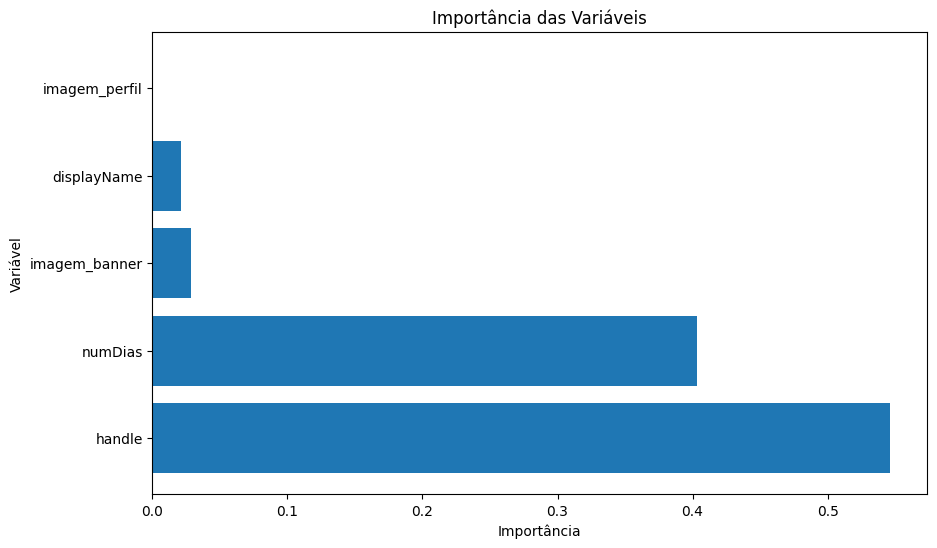

In [88]:
# Importância das Variáveis

importances = rf_model.feature_importances_
feature_names = x_treino.columns
df_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# Visualização
plt.figure(figsize=(10, 6))
plt.barh(df_importances['Feature'], df_importances['Importance'])
plt.xlabel('Importância')
plt.ylabel('Variável')
plt.title('Importância das Variáveis')
plt.show()


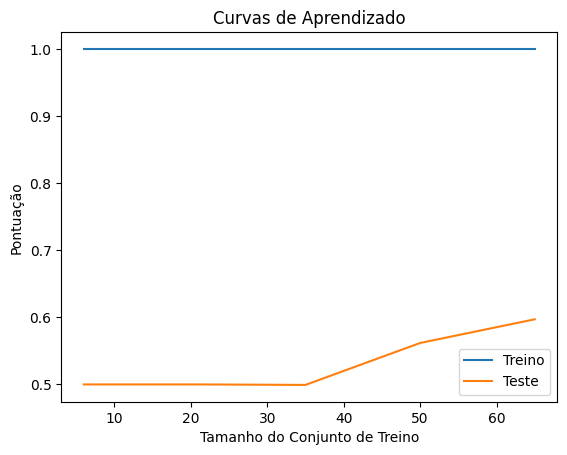

In [89]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(rf_model, x_treino, y_treino, cv=5)
plt.plot(train_sizes, train_scores.mean(axis=1), label='Treino')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Teste')
plt.legend()
plt.xlabel('Tamanho do Conjunto de Treino')
plt.ylabel('Pontuação')
plt.title('Curvas de Aprendizado')
plt.show()


### Naive Bayes

In [90]:
from sklearn.naive_bayes import ComplementNB

In [91]:
# Criar modelo.
model = ComplementNB()

In [92]:
# Treinar modelo.
model.fit(x_treino, y_treino)

ComplementNB()

In [93]:
# Fazer previsões
y_pred = model.predict(x_teste)

In [94]:
# Avaliar o desempenho.
print("Acurácia:", accuracy_score(y_teste, y_pred))
print("\nRelatório de Classificação:\n", classification_report(y_teste, y_pred))

Acurácia: 0.47107438016528924

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.82      0.49      0.61       104
           1       0.10      0.35      0.16        17

    accuracy                           0.47       121
   macro avg       0.46      0.42      0.39       121
weighted avg       0.72      0.47      0.55       121



### Árvore de decisão

In [95]:
from sklearn.tree import DecisionTreeClassifier

In [96]:
# Criar modelo.
model = DecisionTreeClassifier(random_state=0)

In [97]:
# Treinar modelo.
model.fit(x_treino, y_treino)

DecisionTreeClassifier(random_state=0)

In [98]:
# Fazer o modelo prever com base em x_teste.
y_pred = model.predict(x_teste)

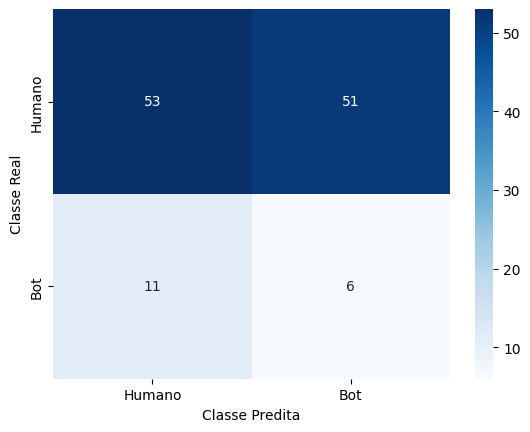

In [99]:
# Matriz de confusão.
from sklearn.metrics import confusion_matrix

# Matriz de confusão
cm = confusion_matrix(y_teste, y_pred)

import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Humano', 'Bot'], yticklabels=['Humano', 'Bot'])
plt.ylabel('Classe Real')
plt.xlabel('Classe Predita')
plt.show()

In [100]:
# Calcular acurácia.
accuracy = accuracy_score(y_teste, y_pred)
accuracy

0.48760330578512395

In [101]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calcular precisão, recall e F1-score
precision = precision_score(y_teste, y_pred)
recall = recall_score(y_teste, y_pred)
f1 = f1_score(y_teste, y_pred)

# capacidade do modelo de não classificar erroneamente exemplos humanos como bots.
# classifica muitos humanos como bots.
print(f'Precisão: {precision:.2f}')

# capacidade do modelo de encontrar todos os bots.
print(f'Recall: {recall:.2f}')

# o mais útil.
print(f'F1-Score: {f1:.2f}')

Precisão: 0.11
Recall: 0.35
F1-Score: 0.16


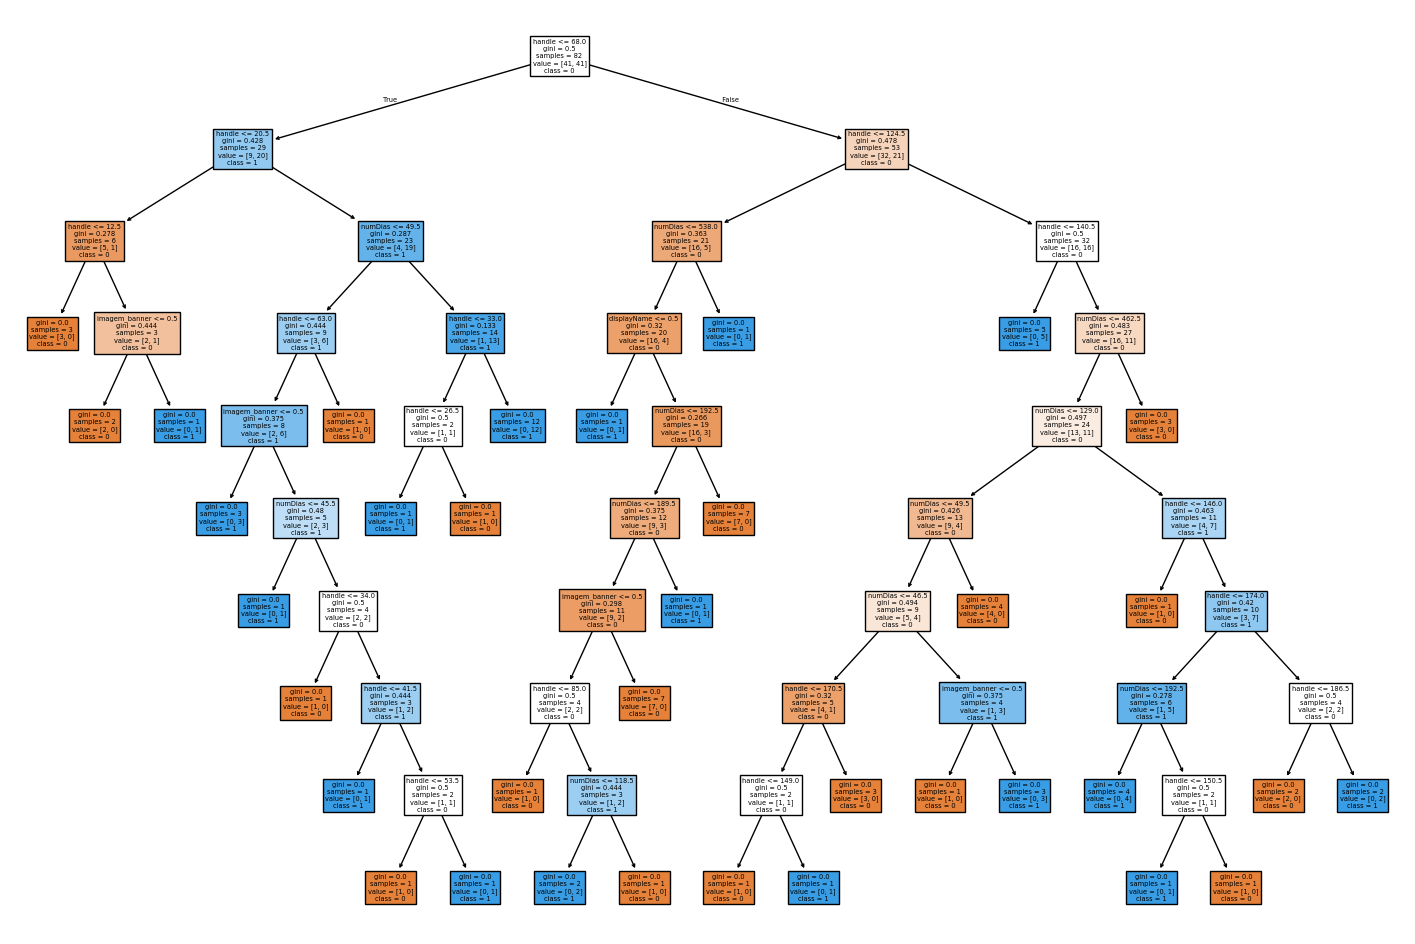

In [102]:
# Visualizar a árvore.
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Plotar a árvore de decisão
plt.figure(figsize=(18, 12))
plot_tree(model, filled=True, feature_names=['handle', 'displayName', 'imagem_perfil', 'imagem_banner', 'numDias'], class_names=['0', '1'])
plt.show()

Testando possibilidades.

In [103]:
from itertools import product

In [104]:
arvores = {}

possibilidades = {
    "altura": [1, 2, 3, 4, 5],
}

combinacoes = list(product(*possibilidades.values()))

for c in combinacoes:
  # Criar modelo.
  model = DecisionTreeClassifier(random_state=0, max_depth=c[0])
  # Treinar modelo.
  model.fit(x_treino, y_treino)
  # Fazer o modelo prever com base em x_teste.
  y_pred = model.predict(x_teste)
  # Calcular acurácia.
  accuracy = accuracy_score(y_teste, y_pred)
  # capacidade do modelo de não classificar erroneamente exemplos humanos como bots.
  # classifica muitos humanos como bots.
  precision = precision_score(y_teste, y_pred)
  # capacidade do modelo de encontrar todos os bots.
  recall = recall_score(y_teste, y_pred)
  # o mais útil.
  f1 = f1_score(y_teste, y_pred)
  arvores[f"Altura: {c[0]}"] = f"Acurácia: {accuracy:.2f}; precisão: {precision:.2f}; recall: {recall:.2f}; f1: {f1:.2f}"

In [105]:
arvores

{'Altura: 1': 'Acurácia: 0.63; precisão: 0.15; recall: 0.35; f1: 0.21',
 'Altura: 2': 'Acurácia: 0.70; precisão: 0.12; recall: 0.18; f1: 0.14',
 'Altura: 3': 'Acurácia: 0.58; precisão: 0.07; recall: 0.18; f1: 0.11',
 'Altura: 4': 'Acurácia: 0.64; precisão: 0.14; recall: 0.29; f1: 0.19',
 'Altura: 5': 'Acurácia: 0.57; precisão: 0.13; recall: 0.35; f1: 0.19'}

### Regressão Logística

In [106]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [107]:
# Criando o Modelo.
model = LogisticRegression()

In [108]:
# Treinando o modelo.
model.fit(x_treino, y_treino)

LogisticRegression()

In [109]:
# Fazer previsões.
y_pred = model.predict(x_teste)

In [110]:
# Avaliar o modelo
print("Acurácia:", accuracy_score(y_teste, y_pred))
print("Relatório de Classificação:\n", classification_report(y_teste, y_pred))

# precisão: 78%
# recall: 69%
# f1-score: 75%

Acurácia: 0.5041322314049587
Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.87      0.50      0.63       104
           1       0.15      0.53      0.23        17

    accuracy                           0.50       121
   macro avg       0.51      0.51      0.43       121
weighted avg       0.77      0.50      0.58       121



In [111]:
import pandas as pd
coef = pd.DataFrame({
    "Atributo": x_treino.columns,
    "Coeficiente": model.coef_[0]
}).sort_values(by="Coeficiente", ascending=False)
print(coef)

        Atributo  Coeficiente
1    displayName     0.561650
4        numDias    -0.000394
2  imagem_perfil    -0.004410
0         handle    -0.005053
3  imagem_banner    -0.029473


## Apenas com Comportamento da Conta

### Importação da Base e Transformação de Atributos

In [112]:
# Fazer upload do arquivo .xlsm
uploaded = files.upload()

# Nome do arquivo (ajuste se necessário)
base_dados = list(uploaded.keys())[0]

# Ler o arquivo .xlsm
base = pd.read_excel(base_dados, engine='openpyxl', sheet_name='dados')

Saving apenas_interacoes_conta.xlsm to apenas_interacoes_conta.xlsm


In [113]:
# Handle.
from sklearn.preprocessing import LabelEncoder

In [114]:
label_encoder = LabelEncoder()

In [115]:
base['handle'] = label_encoder.fit_transform(base['handle'])

In [116]:
# Variáveis binárias.

In [117]:
# displayName.
for i, d in enumerate(base['displayName']):
  if pd.isna(d):
    base.at[i, 'displayName'] = 0
  else:
    base.at[i, 'displayName'] = 1

In [118]:
# classificacao
base['classificacao'] = base['classificacao'].map({'bot': 1, 'humano': 0})

In [119]:
# sentimento_mais_frequente
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
sentimento_encoded = encoder.fit_transform(base[['sentimento_mais_frequente']])
df_encoded = pd.DataFrame(sentimento_encoded, columns=encoder.get_feature_names_out(['sentimento_mais_frequente']))
base = base.drop('sentimento_mais_frequente', axis=1)
base = pd.concat([base, df_encoded], axis=1)

### Classificação e separação dos conjuntos

In [120]:
# Linhas de usuários bots.
bots = base[base["classificacao"] == 1]

In [121]:
# Filtrar 70% dos bots, para compôr o conjunto de treinamento.
bots_treinamento = bots.sample(frac=0.7, random_state=0)

In [122]:
# Lista de usuários humanos.
humanos = base[base["classificacao"] == 0]

In [123]:
# Filtrar a mesma quantidade de humanos, para complementar o conjunto de treinamento.
humanos_treinamento = humanos.sample(n=41, random_state=0) # a quantidade 41 é obtida na primeira separação do conjunto em teste x treinamento

In [124]:
# Conjunto de treinamento.
treinamento = pd.concat([bots_treinamento, humanos_treinamento], axis=0, ignore_index=True)

In [125]:
# Montar o conjunto de teste e validação com os usuários fora do treinamento.
todos_handles = set(base['handle'])
handles_treinamento = set(treinamento['handle'])

handles_teste = todos_handles - handles_treinamento

teste = base[base['handle'].isin(handles_teste)]

### Random Forest

In [126]:
from sklearn.ensemble import RandomForestClassifier # importando o modelo

In [127]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score, classification_report # importanto as métricas

In [128]:
import matplotlib.pyplot as plt

In [129]:
# Separar o conjunto de treinamento entre variáveis X e Y.
x_treino = treinamento.drop('classificacao', axis=1)
y_treino = treinamento['classificacao']

In [130]:
# Separar o conjunto de teste entre variáveis X e Y.
x_teste = teste.drop('classificacao', axis=1)
y_teste = teste['classificacao']

In [131]:
# Criar modelo.
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

In [132]:
# Treinar o modelo
rf_model.fit(x_treino, y_treino)

RandomForestClassifier(random_state=42)

In [133]:
# Fazer previsões
y_pred = rf_model.predict(x_teste)

In [134]:
# Avaliar o desempenho
print("Acurácia:", accuracy_score(y_teste, y_pred))
print("\nMatriz de Confusão:\n", confusion_matrix(y_teste, y_pred))
print("\nRelatório de Classificação:\n", classification_report(y_teste, y_pred))

# Precisão: 86%
# Recall: 77%
# F1-score: 80%

Acurácia: 0.743801652892562

Matriz de Confusão:
 [[78 26]
 [ 5 12]]

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.94      0.75      0.83       104
           1       0.32      0.71      0.44        17

    accuracy                           0.74       121
   macro avg       0.63      0.73      0.64       121
weighted avg       0.85      0.74      0.78       121



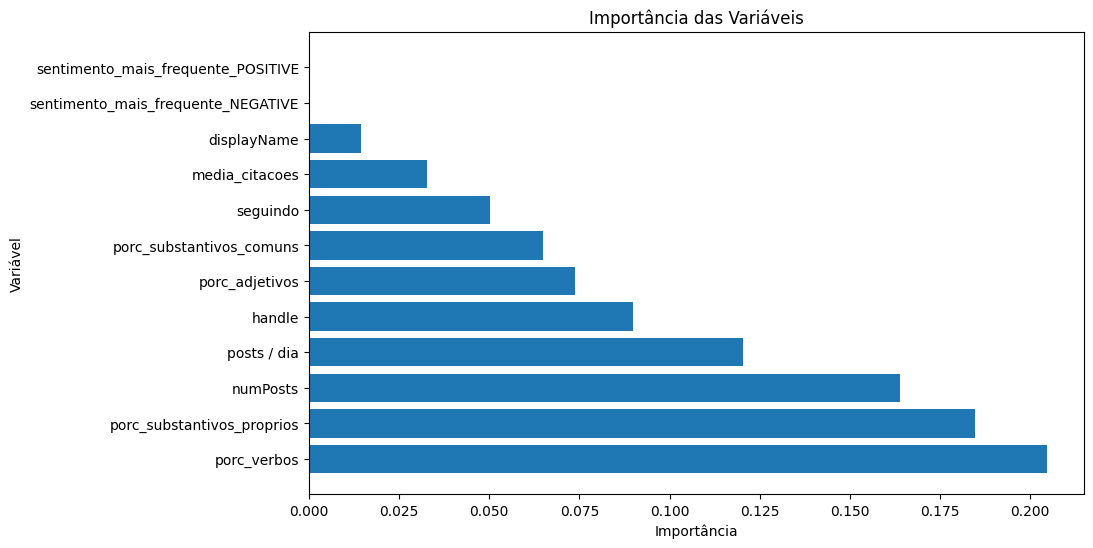

In [135]:
# Importância das Variáveis

importances = rf_model.feature_importances_
feature_names = x_treino.columns
df_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# Visualização
plt.figure(figsize=(10, 6))
plt.barh(df_importances['Feature'], df_importances['Importance'])
plt.xlabel('Importância')
plt.ylabel('Variável')
plt.title('Importância das Variáveis')
plt.show()


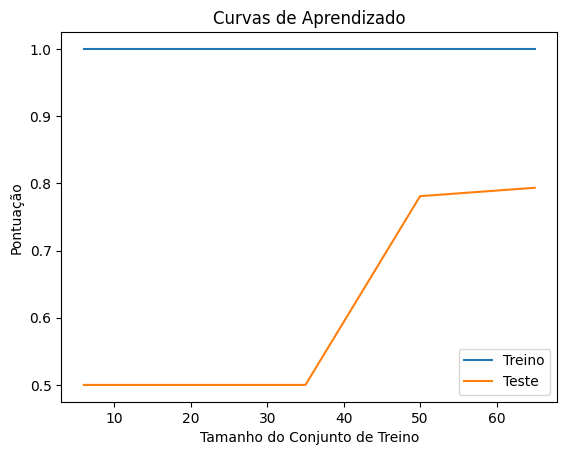

In [136]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(rf_model, x_treino, y_treino, cv=5)
plt.plot(train_sizes, train_scores.mean(axis=1), label='Treino')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Teste')
plt.legend()
plt.xlabel('Tamanho do Conjunto de Treino')
plt.ylabel('Pontuação')
plt.title('Curvas de Aprendizado')
plt.show()


### Naive Bayes

In [137]:
from sklearn.naive_bayes import ComplementNB

In [138]:
# Criar modelo.
model = ComplementNB()

In [139]:
# Treinar modelo.
model.fit(x_treino, y_treino)

ComplementNB()

In [140]:
# Fazer previsões
y_pred = model.predict(x_teste)

In [141]:
# Avaliar o desempenho.
print("Acurácia:", accuracy_score(y_teste, y_pred))
print("\nRelatório de Classificação:\n", classification_report(y_teste, y_pred))

Acurácia: 0.5537190082644629

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.90      0.54      0.67       104
           1       0.19      0.65      0.29        17

    accuracy                           0.55       121
   macro avg       0.54      0.59      0.48       121
weighted avg       0.80      0.55      0.62       121



### Árvore de decisão

In [142]:
from sklearn.tree import DecisionTreeClassifier

In [143]:
# Criar modelo.
model = DecisionTreeClassifier(random_state=0)

In [144]:
# Treinar modelo.
model.fit(x_treino, y_treino)

DecisionTreeClassifier(random_state=0)

In [145]:
# Fazer o modelo prever com base em x_teste.
y_pred = model.predict(x_teste)

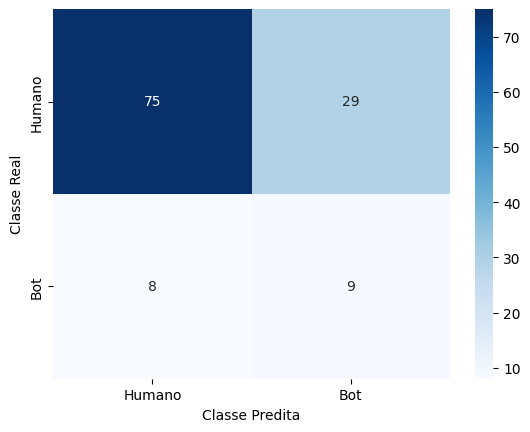

In [146]:
# Matriz de confusão.
from sklearn.metrics import confusion_matrix

# Matriz de confusão
cm = confusion_matrix(y_teste, y_pred)

import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Humano', 'Bot'], yticklabels=['Humano', 'Bot'])
plt.ylabel('Classe Real')
plt.xlabel('Classe Predita')
plt.show()

In [147]:
# Calcular acurácia.
accuracy = accuracy_score(y_teste, y_pred)
accuracy

0.6942148760330579

In [148]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calcular precisão, recall e F1-score
precision = precision_score(y_teste, y_pred)
recall = recall_score(y_teste, y_pred)
f1 = f1_score(y_teste, y_pred)

# capacidade do modelo de não classificar erroneamente exemplos humanos como bots.
# classifica muitos humanos como bots.
print(f'Precisão: {precision:.2f}')

# capacidade do modelo de encontrar todos os bots.
print(f'Recall: {recall:.2f}')

# o mais útil.
print(f'F1-Score: {f1:.2f}')

Precisão: 0.24
Recall: 0.53
F1-Score: 0.33


Testando possibilidades.

In [149]:
from itertools import product

In [150]:
arvores = {}

possibilidades = {
    "altura": [1, 2, 3, 4, 5],
}

combinacoes = list(product(*possibilidades.values()))

for c in combinacoes:
  # Criar modelo.
  model = DecisionTreeClassifier(random_state=0, max_depth=c[0])
  # Treinar modelo.
  model.fit(x_treino, y_treino)
  # Fazer o modelo prever com base em x_teste.
  y_pred = model.predict(x_teste)
  # Calcular acurácia.
  accuracy = accuracy_score(y_teste, y_pred)
  # capacidade do modelo de não classificar erroneamente exemplos humanos como bots.
  # classifica muitos humanos como bots.
  precision = precision_score(y_teste, y_pred)
  # capacidade do modelo de encontrar todos os bots.
  recall = recall_score(y_teste, y_pred)
  # o mais útil.
  f1 = f1_score(y_teste, y_pred)
  arvores[f"Altura: {c[0]}"] = f"Acurácia: {accuracy:.2f}; precisão: {precision:.2f}; recall: {recall:.2f}; f1: {f1:.2f}"

In [151]:
arvores

{'Altura: 1': 'Acurácia: 0.60; precisão: 0.25; recall: 0.88; f1: 0.38',
 'Altura: 2': 'Acurácia: 0.69; precisão: 0.26; recall: 0.65; f1: 0.37',
 'Altura: 3': 'Acurácia: 0.74; precisão: 0.29; recall: 0.59; f1: 0.39',
 'Altura: 4': 'Acurácia: 0.71; precisão: 0.25; recall: 0.53; f1: 0.34',
 'Altura: 5': 'Acurácia: 0.69; precisão: 0.24; recall: 0.53; f1: 0.33'}

### Regressão Logística

In [152]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [153]:
# Criando o Modelo.
model = LogisticRegression()

In [154]:
# Treinando o modelo.
model.fit(x_treino, y_treino)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [155]:
# Fazer previsões.
y_pred = model.predict(x_teste)

In [156]:
# Avaliar o modelo
print("Acurácia:", accuracy_score(y_teste, y_pred))
print("Relatório de Classificação:\n", classification_report(y_teste, y_pred))

# precisão: 78%
# recall: 69%
# f1-score: 75%

Acurácia: 0.6694214876033058
Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.90      0.69      0.78       104
           1       0.22      0.53      0.31        17

    accuracy                           0.67       121
   macro avg       0.56      0.61      0.55       121
weighted avg       0.80      0.67      0.72       121



In [157]:
import pandas as pd
coef = pd.DataFrame({
    "Atributo": x_treino.columns,
    "Coeficiente": model.coef_[0]
}).sort_values(by="Coeficiente", ascending=False)
print(coef)

                              Atributo  Coeficiente
5           porc_substantivos_proprios     1.073724
9                       media_citacoes     0.951239
1                          displayName     0.461318
3                          posts / dia     0.014932
2                             numPosts     0.000687
4                             seguindo     0.000036
11  sentimento_mais_frequente_POSITIVE     0.000000
0                               handle    -0.009396
8                       porc_adjetivos    -0.176433
10  sentimento_mais_frequente_NEGATIVE    -0.240855
6             porc_substantivos_comuns    -0.516154
7                          porc_verbos    -0.621992


## Apenas com Interações de outros usuários

### Importação da Base e Transformação de Atributos

In [158]:
# Fazer upload do arquivo .xlsm
uploaded = files.upload()

# Nome do arquivo (ajuste se necessário)
base_dados = list(uploaded.keys())[0]

# Ler o arquivo .xlsm
base = pd.read_excel(base_dados, engine='openpyxl', sheet_name='dados')

Saving apenas_interações_terceiros.xlsm to apenas_interações_terceiros.xlsm


In [159]:
# Handle.
from sklearn.preprocessing import LabelEncoder

In [160]:
label_encoder = LabelEncoder()

In [161]:
base['handle'] = label_encoder.fit_transform(base['handle'])

In [162]:
# Variáveis binárias.

In [163]:
# displayName.
for i, d in enumerate(base['displayName']):
  if pd.isna(d):
    base.at[i, 'displayName'] = 0
  else:
    base.at[i, 'displayName'] = 1

In [164]:
# classificacao
base['classificacao'] = base['classificacao'].map({'bot': 1, 'humano': 0})

### Classificação e separação dos conjuntos

In [165]:
# Linhas de usuários bots.
bots = base[base["classificacao"] == 1]

In [166]:
# Filtrar 70% dos bots, para compôr o conjunto de treinamento.
bots_treinamento = bots.sample(frac=0.7, random_state=0)

In [167]:
# Lista de usuários humanos.
humanos = base[base["classificacao"] == 0]

In [168]:
# Filtrar a mesma quantidade de humanos, para complementar o conjunto de treinamento.
humanos_treinamento = humanos.sample(n=41, random_state=0) # a quantidade 41 é obtida na primeira separação do conjunto em teste x treinamento

In [169]:
# Conjunto de treinamento.
treinamento = pd.concat([bots_treinamento, humanos_treinamento], axis=0, ignore_index=True)

In [170]:
# Montar o conjunto de teste e validação com os usuários fora do treinamento.
todos_handles = set(base['handle'])
handles_treinamento = set(treinamento['handle'])

handles_teste = todos_handles - handles_treinamento

teste = base[base['handle'].isin(handles_teste)]

### Random Forest

In [171]:
from sklearn.ensemble import RandomForestClassifier # importando o modelo

In [172]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score, classification_report # importanto as métricas

In [173]:
import matplotlib.pyplot as plt

In [174]:
# Separar o conjunto de treinamento entre variáveis X e Y.
x_treino = treinamento.drop('classificacao', axis=1)
y_treino = treinamento['classificacao']

In [175]:
# Separar o conjunto de teste entre variáveis X e Y.
x_teste = teste.drop('classificacao', axis=1)
y_teste = teste['classificacao']

In [176]:
# Criar modelo.
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

In [177]:
# Treinar o modelo
rf_model.fit(x_treino, y_treino)

RandomForestClassifier(random_state=42)

In [178]:
# Fazer previsões
y_pred = rf_model.predict(x_teste)

In [179]:
# Avaliar o desempenho
print("Acurácia:", accuracy_score(y_teste, y_pred))
print("\nMatriz de Confusão:\n", confusion_matrix(y_teste, y_pred))
print("\nRelatório de Classificação:\n", classification_report(y_teste, y_pred))

# Precisão: 86%
# Recall: 77%
# F1-score: 80%

Acurácia: 0.5785123966942148

Matriz de Confusão:
 [[66 38]
 [13  4]]

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.84      0.63      0.72       104
           1       0.10      0.24      0.14        17

    accuracy                           0.58       121
   macro avg       0.47      0.43      0.43       121
weighted avg       0.73      0.58      0.64       121



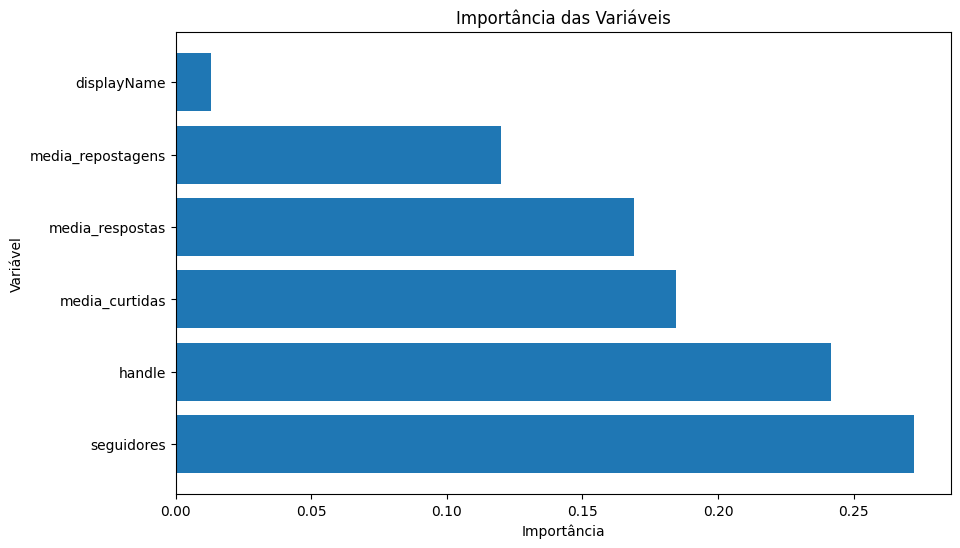

In [180]:
# Importância das Variáveis

importances = rf_model.feature_importances_
feature_names = x_treino.columns
df_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# Visualização
plt.figure(figsize=(10, 6))
plt.barh(df_importances['Feature'], df_importances['Importance'])
plt.xlabel('Importância')
plt.ylabel('Variável')
plt.title('Importância das Variáveis')
plt.show()


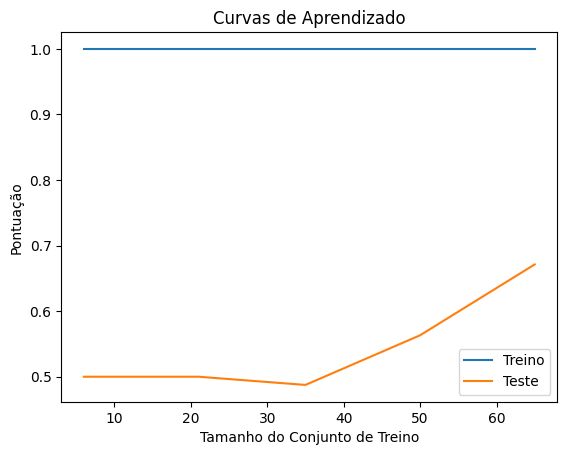

In [181]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(rf_model, x_treino, y_treino, cv=5)
plt.plot(train_sizes, train_scores.mean(axis=1), label='Treino')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Teste')
plt.legend()
plt.xlabel('Tamanho do Conjunto de Treino')
plt.ylabel('Pontuação')
plt.title('Curvas de Aprendizado')
plt.show()


### Naive Bayes

In [182]:
from sklearn.naive_bayes import ComplementNB

In [183]:
# Criar modelo.
model = ComplementNB()

In [184]:
# Treinar modelo.
model.fit(x_treino, y_treino)

ComplementNB()

In [185]:
# Fazer previsões
y_pred = model.predict(x_teste)

In [186]:
# Avaliar o desempenho.
print("Acurácia:", accuracy_score(y_teste, y_pred))
print("\nRelatório de Classificação:\n", classification_report(y_teste, y_pred))

Acurácia: 0.7272727272727273

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.84      0.85      0.84       104
           1       0.00      0.00      0.00        17

    accuracy                           0.73       121
   macro avg       0.42      0.42      0.42       121
weighted avg       0.72      0.73      0.72       121



### Árvore de decisão

In [187]:
from sklearn.tree import DecisionTreeClassifier

In [188]:
# Criar modelo.
model = DecisionTreeClassifier(random_state=0)

In [189]:
# Treinar modelo.
model.fit(x_treino, y_treino)

DecisionTreeClassifier(random_state=0)

In [190]:
# Fazer o modelo prever com base em x_teste.
y_pred = model.predict(x_teste)

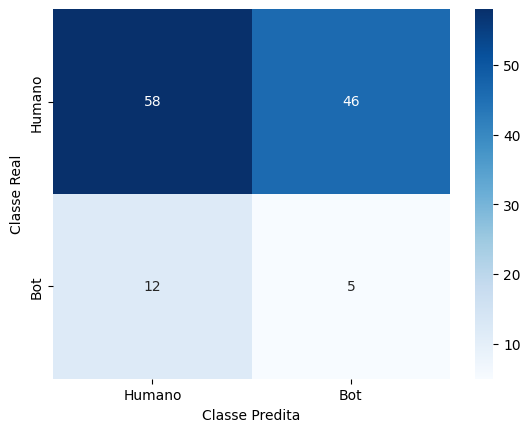

In [191]:
# Matriz de confusão.
from sklearn.metrics import confusion_matrix

# Matriz de confusão
cm = confusion_matrix(y_teste, y_pred)

import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Humano', 'Bot'], yticklabels=['Humano', 'Bot'])
plt.ylabel('Classe Real')
plt.xlabel('Classe Predita')
plt.show()

In [192]:
# Calcular acurácia.
accuracy = accuracy_score(y_teste, y_pred)
accuracy

0.5206611570247934

In [193]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calcular precisão, recall e F1-score
precision = precision_score(y_teste, y_pred)
recall = recall_score(y_teste, y_pred)
f1 = f1_score(y_teste, y_pred)

# capacidade do modelo de não classificar erroneamente exemplos humanos como bots.
# classifica muitos humanos como bots.
print(f'Precisão: {precision:.2f}')

# capacidade do modelo de encontrar todos os bots.
print(f'Recall: {recall:.2f}')

# o mais útil.
print(f'F1-Score: {f1:.2f}')

Precisão: 0.10
Recall: 0.29
F1-Score: 0.15


In [194]:
print(x_treino.shape[1])  # Número de colunas usadas no treinamento

6


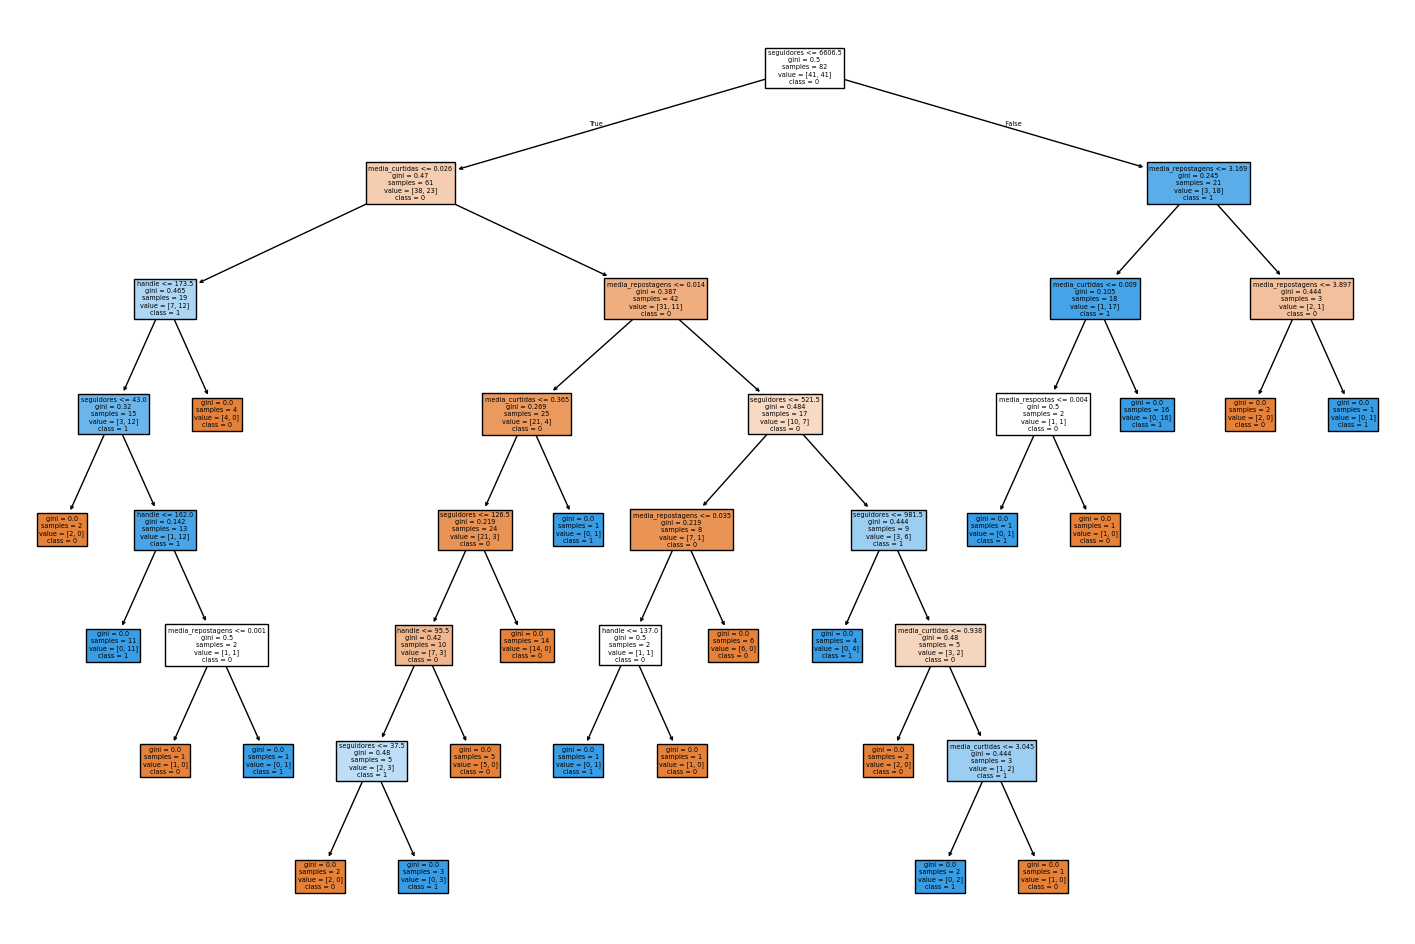

In [195]:
# Visualizar a árvore.
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Plotar a árvore de decisão
plt.figure(figsize=(18, 12))
plot_tree(model, filled=True, feature_names=['handle', 'displayName', 'seguidores', 'media_respostas', 'media_repostagens', 'media_curtidas'], class_names=['0', '1'])
plt.show()

Testando possibilidades.

In [196]:
from itertools import product

In [197]:
arvores = {}

possibilidades = {
    "altura": [1, 2, 3, 4, 5],
}

combinacoes = list(product(*possibilidades.values()))

for c in combinacoes:
  # Criar modelo.
  model = DecisionTreeClassifier(random_state=0, max_depth=c[0])
  # Treinar modelo.
  model.fit(x_treino, y_treino)
  # Fazer o modelo prever com base em x_teste.
  y_pred = model.predict(x_teste)
  # Calcular acurácia.
  accuracy = accuracy_score(y_teste, y_pred)
  # capacidade do modelo de não classificar erroneamente exemplos humanos como bots.
  # classifica muitos humanos como bots.
  precision = precision_score(y_teste, y_pred)
  # capacidade do modelo de encontrar todos os bots.
  recall = recall_score(y_teste, y_pred)
  # o mais útil.
  f1 = f1_score(y_teste, y_pred)
  arvores[f"Altura: {c[0]}"] = f"Acurácia: {accuracy:.2f}; precisão: {precision:.2f}; recall: {recall:.2f}; f1: {f1:.2f}"

In [198]:
arvores

{'Altura: 1': 'Acurácia: 0.79; precisão: 0.00; recall: 0.00; f1: 0.00',
 'Altura: 2': 'Acurácia: 0.60; precisão: 0.14; recall: 0.35; f1: 0.20',
 'Altura: 3': 'Acurácia: 0.64; precisão: 0.14; recall: 0.29; f1: 0.19',
 'Altura: 4': 'Acurácia: 0.59; precisão: 0.16; recall: 0.47; f1: 0.24',
 'Altura: 5': 'Acurácia: 0.64; precisão: 0.11; recall: 0.24; f1: 0.15'}

### Regressão Logística

In [199]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [200]:
# Criando o Modelo.
model = LogisticRegression()

In [201]:
# Treinando o modelo.
model.fit(x_treino, y_treino)

LogisticRegression()

In [202]:
# Fazer previsões.
y_pred = model.predict(x_teste)

In [203]:
# Avaliar o modelo
print("Acurácia:", accuracy_score(y_teste, y_pred))
print("Relatório de Classificação:\n", classification_report(y_teste, y_pred))

# precisão: 78%
# recall: 69%
# f1-score: 75%

Acurácia: 0.6694214876033058
Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.86      0.74      0.79       104
           1       0.13      0.24      0.17        17

    accuracy                           0.67       121
   macro avg       0.49      0.49      0.48       121
weighted avg       0.75      0.67      0.71       121



In [204]:
import pandas as pd
coef = pd.DataFrame({
    "Atributo": x_treino.columns,
    "Coeficiente": model.coef_[0]
}).sort_values(by="Coeficiente", ascending=False)
print(coef)

            Atributo  Coeficiente
1        displayName     0.356069
3    media_respostas     0.099827
4  media_repostagens     0.083852
2         seguidores     0.000064
0             handle    -0.004430
5     media_curtidas    -0.162291


## Atributos da Conta + Comportamento da conta

### Importação da Base e Transformação de Atributos

In [205]:
# Fazer upload do arquivo .xlsm
uploaded = files.upload()

# Nome do arquivo (ajuste se necessário)
base_dados = list(uploaded.keys())[0]

# Ler o arquivo .xlsm
base = pd.read_excel(base_dados, engine='openpyxl', sheet_name='dados')

Saving atributos_e_interacoes_conta.xlsm to atributos_e_interacoes_conta.xlsm


In [206]:
# Handle.
from sklearn.preprocessing import LabelEncoder

In [207]:
label_encoder = LabelEncoder()

In [208]:
base['handle'] = label_encoder.fit_transform(base['handle'])

In [209]:
# Variáveis binárias.
# imagem_perfil
base['imagem_perfil'] = base['imagem_perfil'].map({'Sim': 1, 'Nao': 0})

# imagem_banner
base['imagem_banner'] = base['imagem_banner'].map({'Sim': 1, 'Nao': 0})

In [210]:
# displayName.
for i, d in enumerate(base['displayName']):
  if pd.isna(d):
    base.at[i, 'displayName'] = 0
  else:
    base.at[i, 'displayName'] = 1

In [211]:
# sentimento_mais_frequente
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
sentimento_encoded = encoder.fit_transform(base[['sentimento_mais_frequente']])
df_encoded = pd.DataFrame(sentimento_encoded, columns=encoder.get_feature_names_out(['sentimento_mais_frequente']))
base = base.drop('sentimento_mais_frequente', axis=1)
base = pd.concat([base, df_encoded], axis=1)

In [212]:
# classificacao
base['classificacao'] = base['classificacao'].map({'bot': 1, 'humano': 0})

### Classificação e separação dos conjuntos

In [213]:
# Linhas de usuários bots.
bots = base[base["classificacao"] == 1]

In [214]:
# Filtrar 70% dos bots, para compôr o conjunto de treinamento.
bots_treinamento = bots.sample(frac=0.7, random_state=0)

In [215]:
# Lista de usuários humanos.
humanos = base[base["classificacao"] == 0]

In [216]:
# Filtrar a mesma quantidade de humanos, para complementar o conjunto de treinamento.
humanos_treinamento = humanos.sample(n=41, random_state=0) # a quantidade 41 é obtida na primeira separação do conjunto em teste x treinamento

In [217]:
# Conjunto de treinamento.
treinamento = pd.concat([bots_treinamento, humanos_treinamento], axis=0, ignore_index=True)

In [218]:
# Montar o conjunto de teste e validação com os usuários fora do treinamento.
todos_handles = set(base['handle'])
handles_treinamento = set(treinamento['handle'])

handles_teste = todos_handles - handles_treinamento

teste = base[base['handle'].isin(handles_teste)]

### Random Forest

In [219]:
from sklearn.ensemble import RandomForestClassifier # importando o modelo

In [220]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score, classification_report # importanto as métricas

In [221]:
import matplotlib.pyplot as plt

In [222]:
# Separar o conjunto de treinamento entre variáveis X e Y.
x_treino = treinamento.drop('classificacao', axis=1)
y_treino = treinamento['classificacao']

In [223]:
# Separar o conjunto de teste entre variáveis X e Y.
x_teste = teste.drop('classificacao', axis=1)
y_teste = teste['classificacao']

In [224]:
# Criar modelo.
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

In [225]:
# Treinar o modelo
rf_model.fit(x_treino, y_treino)

RandomForestClassifier(random_state=42)

In [226]:
# Fazer previsões
y_pred = rf_model.predict(x_teste)

In [227]:
# Avaliar o desempenho
print("Acurácia:", accuracy_score(y_teste, y_pred))
print("\nMatriz de Confusão:\n", confusion_matrix(y_teste, y_pred))
print("\nRelatório de Classificação:\n", classification_report(y_teste, y_pred))

# Precisão: 86%
# Recall: 77%
# F1-score: 80%

Acurácia: 0.7603305785123967

Matriz de Confusão:
 [[80 24]
 [ 5 12]]

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.94      0.77      0.85       104
           1       0.33      0.71      0.45        17

    accuracy                           0.76       121
   macro avg       0.64      0.74      0.65       121
weighted avg       0.86      0.76      0.79       121



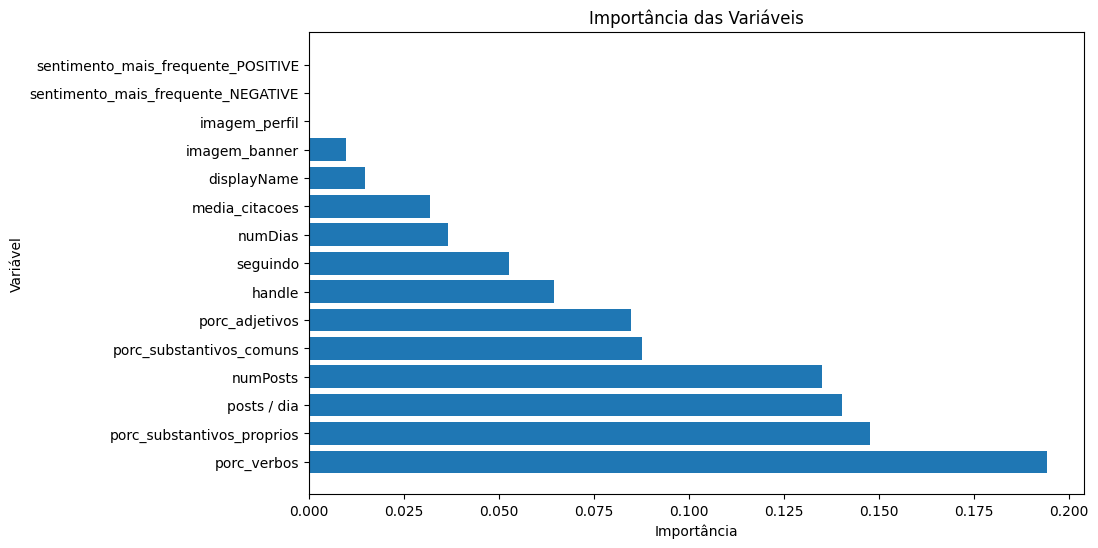

In [228]:
# Importância das Variáveis

importances = rf_model.feature_importances_
feature_names = x_treino.columns
df_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# Visualização
plt.figure(figsize=(10, 6))
plt.barh(df_importances['Feature'], df_importances['Importance'])
plt.xlabel('Importância')
plt.ylabel('Variável')
plt.title('Importância das Variáveis')
plt.show()


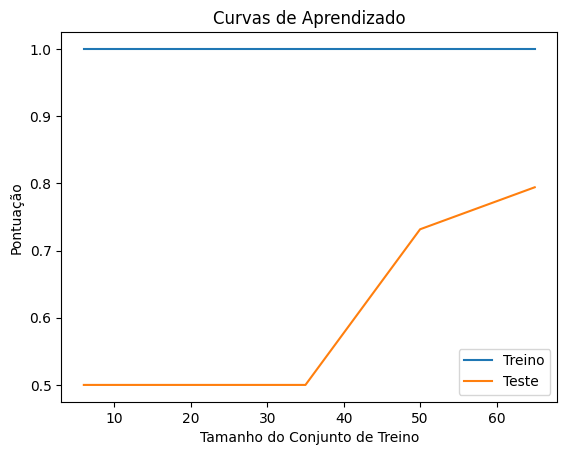

In [229]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(rf_model, x_treino, y_treino, cv=5)
plt.plot(train_sizes, train_scores.mean(axis=1), label='Treino')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Teste')
plt.legend()
plt.xlabel('Tamanho do Conjunto de Treino')
plt.ylabel('Pontuação')
plt.title('Curvas de Aprendizado')
plt.show()


### Naive Bayes

In [230]:
from sklearn.naive_bayes import ComplementNB

In [231]:
# Criar modelo.
model = ComplementNB()

In [232]:
# Treinar modelo.
model.fit(x_treino, y_treino)

ComplementNB()

In [233]:
# Fazer previsões
y_pred = model.predict(x_teste)

In [234]:
# Avaliar o desempenho.
print("Acurácia:", accuracy_score(y_teste, y_pred))
print("\nRelatório de Classificação:\n", classification_report(y_teste, y_pred))

Acurácia: 0.6776859504132231

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.91      0.69      0.79       104
           1       0.24      0.59      0.34        17

    accuracy                           0.68       121
   macro avg       0.57      0.64      0.56       121
weighted avg       0.82      0.68      0.72       121



### Árvore de decisão

In [235]:
from sklearn.tree import DecisionTreeClassifier

In [236]:
# Criar modelo.
model = DecisionTreeClassifier(random_state=0)

In [237]:
# Treinar modelo.
model.fit(x_treino, y_treino)

DecisionTreeClassifier(random_state=0)

In [238]:
# Fazer o modelo prever com base em x_teste.
y_pred = model.predict(x_teste)

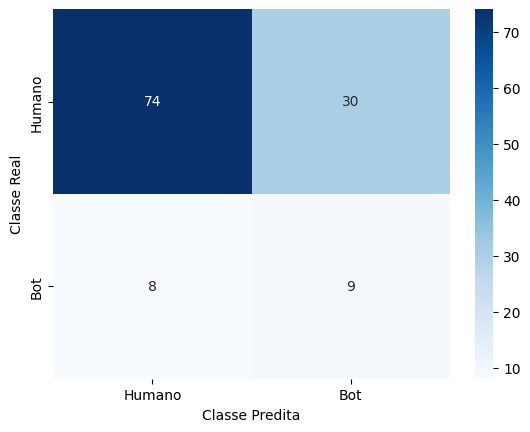

In [239]:
# Matriz de confusão.
from sklearn.metrics import confusion_matrix

# Matriz de confusão
cm = confusion_matrix(y_teste, y_pred)

import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Humano', 'Bot'], yticklabels=['Humano', 'Bot'])
plt.ylabel('Classe Real')
plt.xlabel('Classe Predita')
plt.show()

In [240]:
# Calcular acurácia.
accuracy = accuracy_score(y_teste, y_pred)
accuracy

0.6859504132231405

In [241]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calcular precisão, recall e F1-score
precision = precision_score(y_teste, y_pred)
recall = recall_score(y_teste, y_pred)
f1 = f1_score(y_teste, y_pred)

# capacidade do modelo de não classificar erroneamente exemplos humanos como bots.
# classifica muitos humanos como bots.
print(f'Precisão: {precision:.2f}')

# capacidade do modelo de encontrar todos os bots.
print(f'Recall: {recall:.2f}')

# o mais útil.
print(f'F1-Score: {f1:.2f}')

Precisão: 0.23
Recall: 0.53
F1-Score: 0.32


In [242]:
print(x_treino.shape[1])  # Número de colunas usadas no treinamento

15


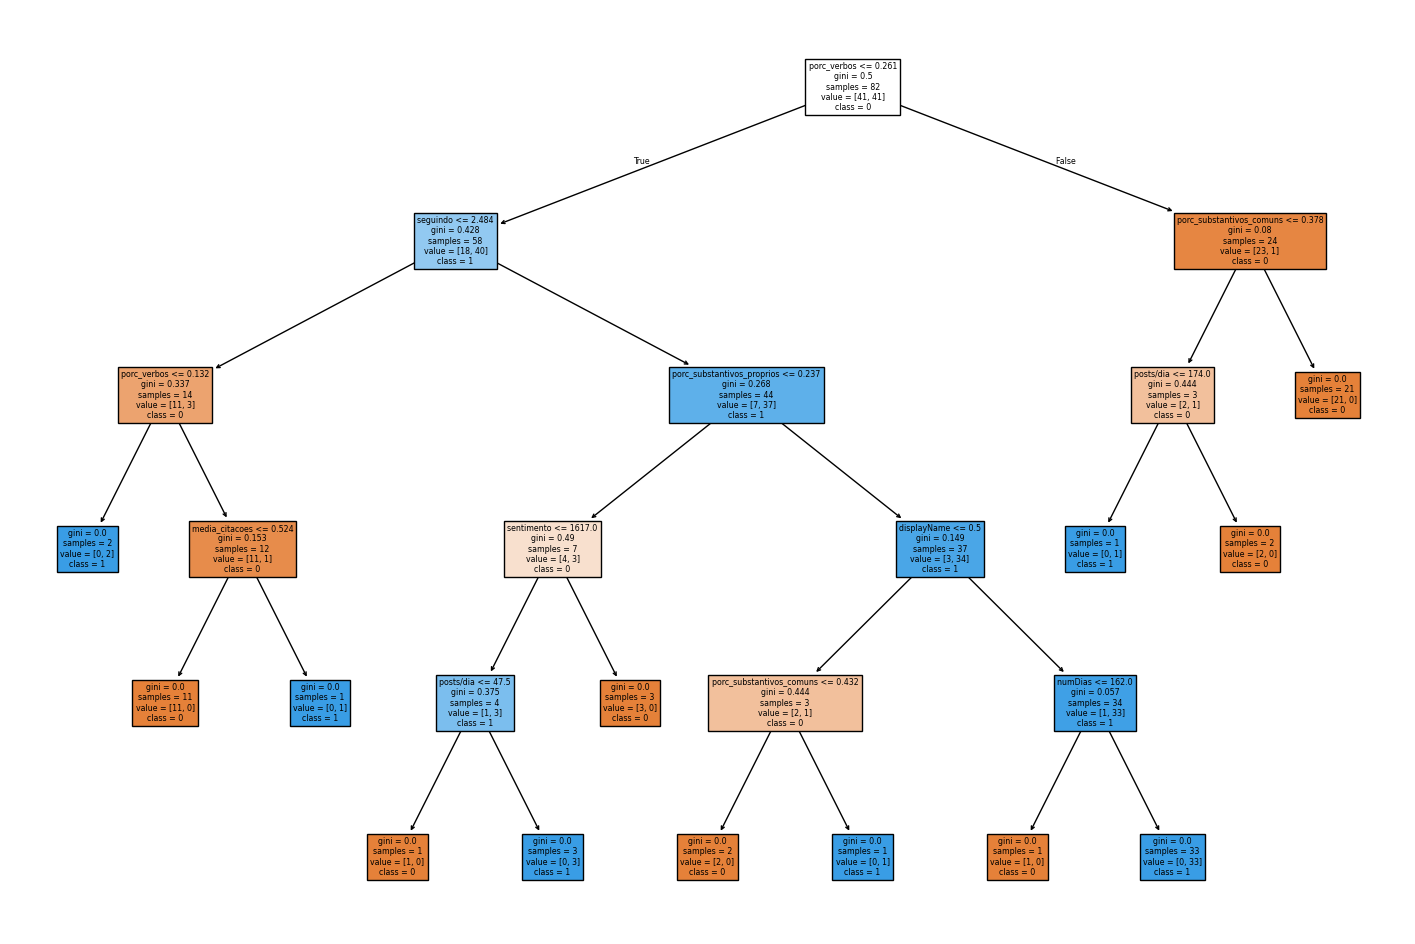

In [243]:
# Visualizar a árvore.
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Plotar a árvore de decisão
plt.figure(figsize=(18, 12))
plot_tree(model, filled=True, feature_names=['handle', 'displayName', 'imagem_banner', 'numPosts', 'numDias', 'posts/dia', 'seguindo', 'sentimento','porc_substantivos_proprios','porc_substantivos_comuns','porc_verbos','porc_adjetivos', 'media_citacoes'], class_names=['0', '1'])
plt.show()

Testando possibilidades.

In [244]:
from itertools import product

In [245]:
arvores = {}

possibilidades = {
    "altura": [1, 2, 3, 4, 5],
}

combinacoes = list(product(*possibilidades.values()))

for c in combinacoes:
  # Criar modelo.
  model = DecisionTreeClassifier(random_state=0, max_depth=c[0])
  # Treinar modelo.
  model.fit(x_treino, y_treino)
  # Fazer o modelo prever com base em x_teste.
  y_pred = model.predict(x_teste)
  # Calcular acurácia.
  accuracy = accuracy_score(y_teste, y_pred)
  # capacidade do modelo de não classificar erroneamente exemplos humanos como bots.
  # classifica muitos humanos como bots.
  precision = precision_score(y_teste, y_pred)
  # capacidade do modelo de encontrar todos os bots.
  recall = recall_score(y_teste, y_pred)
  # o mais útil.
  f1 = f1_score(y_teste, y_pred)
  arvores[f"Altura: {c[0]}"] = f"Acurácia: {accuracy:.2f}; precisão: {precision:.2f}; recall: {recall:.2f}; f1: {f1:.2f}"

In [246]:
arvores

{'Altura: 1': 'Acurácia: 0.60; precisão: 0.25; recall: 0.88; f1: 0.38',
 'Altura: 2': 'Acurácia: 0.69; precisão: 0.26; recall: 0.65; f1: 0.37',
 'Altura: 3': 'Acurácia: 0.72; precisão: 0.28; recall: 0.65; f1: 0.39',
 'Altura: 4': 'Acurácia: 0.67; precisão: 0.24; recall: 0.65; f1: 0.35',
 'Altura: 5': 'Acurácia: 0.69; precisão: 0.23; recall: 0.53; f1: 0.32'}

### Regressão Logística

In [247]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [248]:
# Criando o Modelo.
model = LogisticRegression()

In [249]:
# Treinando o modelo.
model.fit(x_treino, y_treino)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [250]:
# Fazer previsões.
y_pred = model.predict(x_teste)

In [251]:
# Avaliar o modelo
print("Acurácia:", accuracy_score(y_teste, y_pred))
print("Relatório de Classificação:\n", classification_report(y_teste, y_pred))

# precisão: 78%
# recall: 69%
# f1-score: 75%

Acurácia: 0.5950413223140496
Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.89      0.61      0.72       104
           1       0.18      0.53      0.27        17

    accuracy                           0.60       121
   macro avg       0.53      0.57      0.49       121
weighted avg       0.79      0.60      0.66       121



In [252]:
import pandas as pd
coef = pd.DataFrame({
    "Atributo": x_treino.columns,
    "Coeficiente": model.coef_[0]
}).sort_values(by="Coeficiente", ascending=False)
print(coef)

                              Atributo  Coeficiente
12                      media_citacoes     0.849905
8           porc_substantivos_proprios     0.764471
1                          displayName     0.585884
2                        imagem_perfil     0.126937
13  sentimento_mais_frequente_NEGATIVE     0.126937
4                             numPosts     0.001663
7                             seguindo     0.000035
14  sentimento_mais_frequente_POSITIVE     0.000000
5                              numDias    -0.004887
0                               handle    -0.012133
6                          posts / dia    -0.043952
11                      porc_adjetivos    -0.083502
9             porc_substantivos_comuns    -0.203304
3                        imagem_banner    -0.268999
10                         porc_verbos    -0.350729


## Comportamento da conta + Comportamento de terceiros

### Importação da Base e Transformação de Atributos

In [253]:
# Fazer upload do arquivo .xlsm
uploaded = files.upload()

# Nome do arquivo (ajuste se necessário)
base_dados = list(uploaded.keys())[0]

# Ler o arquivo .xlsm
base = pd.read_excel(base_dados, engine='openpyxl', sheet_name='dados')

Saving interacoes_terceiros_e_conta.xlsm to interacoes_terceiros_e_conta.xlsm


In [254]:
# Handle.
from sklearn.preprocessing import LabelEncoder

In [255]:
label_encoder = LabelEncoder()

In [256]:
base['handle'] = label_encoder.fit_transform(base['handle'])

In [257]:
# Variáveis binárias.
# sentimento_mais_frequente
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
sentimento_encoded = encoder.fit_transform(base[['sentimento_mais_frequente']])
df_encoded = pd.DataFrame(sentimento_encoded, columns=encoder.get_feature_names_out(['sentimento_mais_frequente']))
base = base.drop('sentimento_mais_frequente', axis=1)
base = pd.concat([base, df_encoded], axis=1)

In [258]:
# displayName.
for i, d in enumerate(base['displayName']):
  if pd.isna(d):
    base.at[i, 'displayName'] = 0
  else:
    base.at[i, 'displayName'] = 1

In [259]:
# classificacao
base['classificacao'] = base['classificacao'].map({'bot': 1, 'humano': 0})

### Classificação e separação dos conjuntos

In [260]:
# Linhas de usuários bots.
bots = base[base["classificacao"] == 1]

In [261]:
# Filtrar 70% dos bots, para compôr o conjunto de treinamento.
bots_treinamento = bots.sample(frac=0.7, random_state=0)

In [262]:
# Lista de usuários humanos.
humanos = base[base["classificacao"] == 0]

In [263]:
# Filtrar a mesma quantidade de humanos, para complementar o conjunto de treinamento.
humanos_treinamento = humanos.sample(n=41, random_state=0) # a quantidade 41 é obtida na primeira separação do conjunto em teste x treinamento

In [264]:
# Conjunto de treinamento.
treinamento = pd.concat([bots_treinamento, humanos_treinamento], axis=0, ignore_index=True)

In [265]:
# Montar o conjunto de teste e validação com os usuários fora do treinamento.
todos_handles = set(base['handle'])
handles_treinamento = set(treinamento['handle'])

handles_teste = todos_handles - handles_treinamento

teste = base[base['handle'].isin(handles_teste)]

### Random Forest

In [266]:
from sklearn.ensemble import RandomForestClassifier # importando o modelo

In [267]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score, classification_report # importanto as métricas

In [268]:
import matplotlib.pyplot as plt

In [269]:
# Separar o conjunto de treinamento entre variáveis X e Y.
x_treino = treinamento.drop('classificacao', axis=1)
y_treino = treinamento['classificacao']

In [270]:
# Separar o conjunto de teste entre variáveis X e Y.
x_teste = teste.drop('classificacao', axis=1)
y_teste = teste['classificacao']

In [271]:
# Criar modelo.
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

In [272]:
# Treinar o modelo
rf_model.fit(x_treino, y_treino)

RandomForestClassifier(random_state=42)

In [273]:
# Fazer previsões
y_pred = rf_model.predict(x_teste)

In [274]:
# Avaliar o desempenho
print("Acurácia:", accuracy_score(y_teste, y_pred))
print("\nMatriz de Confusão:\n", confusion_matrix(y_teste, y_pred))
print("\nRelatório de Classificação:\n", classification_report(y_teste, y_pred))

# Precisão: 86%
# Recall: 77%
# F1-score: 80%

Acurácia: 0.743801652892562

Matriz de Confusão:
 [[78 26]
 [ 5 12]]

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.94      0.75      0.83       104
           1       0.32      0.71      0.44        17

    accuracy                           0.74       121
   macro avg       0.63      0.73      0.64       121
weighted avg       0.85      0.74      0.78       121



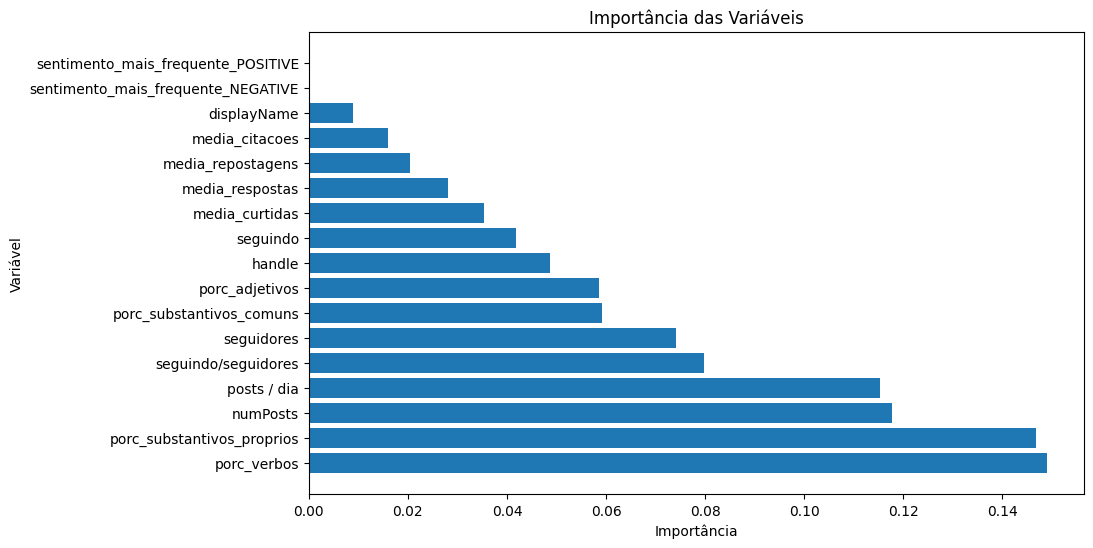

In [275]:
# Importância das Variáveis

importances = rf_model.feature_importances_
feature_names = x_treino.columns
df_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# Visualização
plt.figure(figsize=(10, 6))
plt.barh(df_importances['Feature'], df_importances['Importance'])
plt.xlabel('Importância')
plt.ylabel('Variável')
plt.title('Importância das Variáveis')
plt.show()


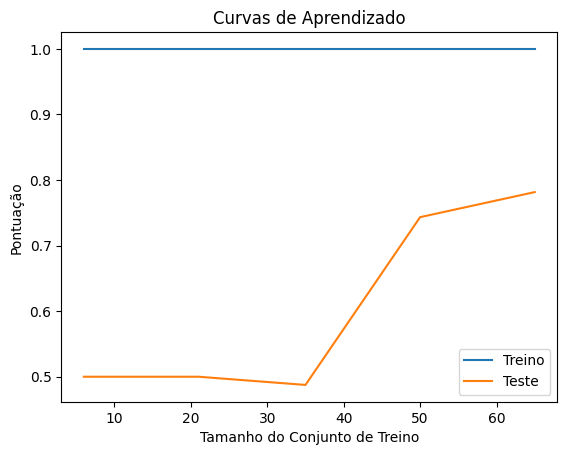

In [276]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(rf_model, x_treino, y_treino, cv=5)
plt.plot(train_sizes, train_scores.mean(axis=1), label='Treino')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Teste')
plt.legend()
plt.xlabel('Tamanho do Conjunto de Treino')
plt.ylabel('Pontuação')
plt.title('Curvas de Aprendizado')
plt.show()


### Naive Bayes

In [277]:
from sklearn.naive_bayes import ComplementNB

In [278]:
# Criar modelo.
model = ComplementNB()

In [279]:
# Treinar modelo.
model.fit(x_treino, y_treino)

ComplementNB()

In [280]:
# Fazer previsões
y_pred = model.predict(x_teste)

In [281]:
# Avaliar o desempenho.
print("Acurácia:", accuracy_score(y_teste, y_pred))
print("\nRelatório de Classificação:\n", classification_report(y_teste, y_pred))

Acurácia: 0.5454545454545454

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.89      0.54      0.67       104
           1       0.17      0.59      0.27        17

    accuracy                           0.55       121
   macro avg       0.53      0.56      0.47       121
weighted avg       0.79      0.55      0.61       121



### Árvore de decisão

In [282]:
from sklearn.tree import DecisionTreeClassifier

In [283]:
# Criar modelo.
model = DecisionTreeClassifier(random_state=0)

In [284]:
# Treinar modelo.
model.fit(x_treino, y_treino)

DecisionTreeClassifier(random_state=0)

In [285]:
# Fazer o modelo prever com base em x_teste.
y_pred = model.predict(x_teste)

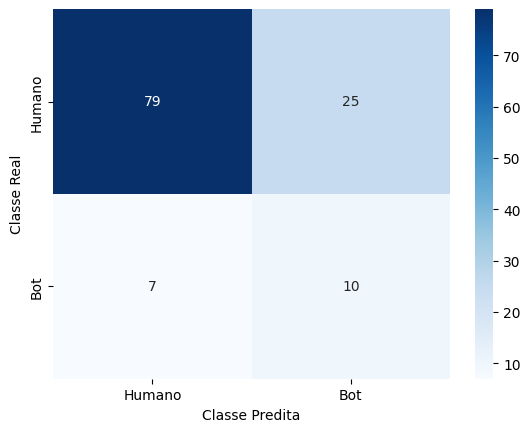

In [286]:
# Matriz de confusão.
from sklearn.metrics import confusion_matrix

# Matriz de confusão
cm = confusion_matrix(y_teste, y_pred)

import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Humano', 'Bot'], yticklabels=['Humano', 'Bot'])
plt.ylabel('Classe Real')
plt.xlabel('Classe Predita')
plt.show()

In [287]:
# Calcular acurácia.
accuracy = accuracy_score(y_teste, y_pred)
accuracy

0.7355371900826446

In [288]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calcular precisão, recall e F1-score
precision = precision_score(y_teste, y_pred)
recall = recall_score(y_teste, y_pred)
f1 = f1_score(y_teste, y_pred)

# capacidade do modelo de não classificar erroneamente exemplos humanos como bots.
# classifica muitos humanos como bots.
print(f'Precisão: {precision:.2f}')

# capacidade do modelo de encontrar todos os bots.
print(f'Recall: {recall:.2f}')

# o mais útil.
print(f'F1-Score: {f1:.2f}')

Precisão: 0.29
Recall: 0.59
F1-Score: 0.38


In [289]:
print(x_treino.shape[1])  # Número de colunas usadas no treinamento

17


Testando possibilidades.

In [290]:
from itertools import product

In [291]:
arvores = {}

possibilidades = {
    "altura": [1, 2, 3, 4, 5],
}

combinacoes = list(product(*possibilidades.values()))

for c in combinacoes:
  # Criar modelo.
  model = DecisionTreeClassifier(random_state=0, max_depth=c[0])
  # Treinar modelo.
  model.fit(x_treino, y_treino)
  # Fazer o modelo prever com base em x_teste.
  y_pred = model.predict(x_teste)
  # Calcular acurácia.
  accuracy = accuracy_score(y_teste, y_pred)
  # capacidade do modelo de não classificar erroneamente exemplos humanos como bots.
  # classifica muitos humanos como bots.
  precision = precision_score(y_teste, y_pred)
  # capacidade do modelo de encontrar todos os bots.
  recall = recall_score(y_teste, y_pred)
  # o mais útil.
  f1 = f1_score(y_teste, y_pred)
  arvores[f"Altura: {c[0]}"] = f"Acurácia: {accuracy:.2f}; precisão: {precision:.2f}; recall: {recall:.2f}; f1: {f1:.2f}"

In [292]:
arvores

{'Altura: 1': 'Acurácia: 0.60; precisão: 0.25; recall: 0.88; f1: 0.38',
 'Altura: 2': 'Acurácia: 0.69; precisão: 0.26; recall: 0.65; f1: 0.37',
 'Altura: 3': 'Acurácia: 0.70; precisão: 0.27; recall: 0.65; f1: 0.38',
 'Altura: 4': 'Acurácia: 0.70; precisão: 0.26; recall: 0.59; f1: 0.36',
 'Altura: 5': 'Acurácia: 0.74; precisão: 0.29; recall: 0.59; f1: 0.38'}

### Regressão Logística

In [293]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [294]:
# Criando o Modelo.
model = LogisticRegression()

In [295]:
# Treinando o modelo.
model.fit(x_treino, y_treino)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [296]:
# Fazer previsões.
y_pred = model.predict(x_teste)

In [297]:
# Avaliar o modelo
print("Acurácia:", accuracy_score(y_teste, y_pred))
print("Relatório de Classificação:\n", classification_report(y_teste, y_pred))

# precisão: 78%
# recall: 69%
# f1-score: 75%

Acurácia: 0.6528925619834711
Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.88      0.69      0.77       104
           1       0.18      0.41      0.25        17

    accuracy                           0.65       121
   macro avg       0.53      0.55      0.51       121
weighted avg       0.78      0.65      0.70       121



In [298]:
import pandas as pd
coef = pd.DataFrame({
    "Atributo": x_treino.columns,
    "Coeficiente": model.coef_[0]
}).sort_values(by="Coeficiente", ascending=False)
print(coef)

                              Atributo  Coeficiente
7           porc_substantivos_proprios     0.035720
14                      media_citacoes     0.012109
3                          posts / dia     0.011570
11                     media_respostas     0.003014
1                          displayName     0.001116
12                   media_repostagens     0.000790
2                             numPosts     0.000543
5                             seguindo     0.000037
4                           seguidores     0.000030
16  sentimento_mais_frequente_POSITIVE     0.000000
10                      porc_adjetivos    -0.007625
0                               handle    -0.008292
9                          porc_verbos    -0.027550
15  sentimento_mais_frequente_NEGATIVE    -0.028038
8             porc_substantivos_comuns    -0.028583
13                      media_curtidas    -0.059185
6                  seguindo/seguidores    -0.069133


## Atributos da Conta + Comportamentos de terceiros

### Importação da Base e Transformação de Atributos

In [299]:
# Fazer upload do arquivo .xlsm
uploaded = files.upload()

# Nome do arquivo (ajuste se necessário)
base_dados = list(uploaded.keys())[0]

# Ler o arquivo .xlsm
base = pd.read_excel(base_dados, engine='openpyxl', sheet_name='dados')

Saving atributos_conta_e_interacoes_terceiros.xlsm to atributos_conta_e_interacoes_terceiros.xlsm


In [300]:
# Handle.
from sklearn.preprocessing import LabelEncoder

In [301]:
label_encoder = LabelEncoder()

In [302]:
base['handle'] = label_encoder.fit_transform(base['handle'])

In [303]:
# Variáveis binárias.

In [304]:
# displayName.
for i, d in enumerate(base['displayName']):
  if pd.isna(d):
    base.at[i, 'displayName'] = 0
  else:
    base.at[i, 'displayName'] = 1

In [305]:
# imagem_perfil
base['imagem_perfil'] = base['imagem_perfil'].map({'Sim': 1, 'Nao': 0})

# imagem_banner
base['imagem_banner'] = base['imagem_banner'].map({'Sim': 1, 'Nao': 0})

In [306]:
# classificacao
base['classificacao'] = base['classificacao'].map({'bot': 1, 'humano': 0})

### Classificação e separação dos conjuntos

In [307]:
# Linhas de usuários bots.
bots = base[base["classificacao"] == 1]

In [308]:
# Filtrar 70% dos bots, para compôr o conjunto de treinamento.
bots_treinamento = bots.sample(frac=0.7, random_state=0)

In [309]:
# Lista de usuários humanos.
humanos = base[base["classificacao"] == 0]

In [310]:
# Filtrar a mesma quantidade de humanos, para complementar o conjunto de treinamento.
humanos_treinamento = humanos.sample(n=41, random_state=0) # a quantidade 41 é obtida na primeira separação do conjunto em teste x treinamento

In [311]:
# Conjunto de treinamento.
treinamento = pd.concat([bots_treinamento, humanos_treinamento], axis=0, ignore_index=True)

In [312]:
# Montar o conjunto de teste e validação com os usuários fora do treinamento.
todos_handles = set(base['handle'])
handles_treinamento = set(treinamento['handle'])

handles_teste = todos_handles - handles_treinamento

teste = base[base['handle'].isin(handles_teste)]

### Random Forest

In [313]:
from sklearn.ensemble import RandomForestClassifier # importando o modelo

In [314]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score, classification_report # importanto as métricas

In [315]:
import matplotlib.pyplot as plt

In [316]:
# Separar o conjunto de treinamento entre variáveis X e Y.
x_treino = treinamento.drop('classificacao', axis=1)
y_treino = treinamento['classificacao']

In [317]:
# Separar o conjunto de teste entre variáveis X e Y.
x_teste = teste.drop('classificacao', axis=1)
y_teste = teste['classificacao']

In [318]:
# Criar modelo.
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

In [319]:
# Treinar o modelo
rf_model.fit(x_treino, y_treino)

RandomForestClassifier(random_state=42)

In [320]:
# Fazer previsões
y_pred = rf_model.predict(x_teste)

In [321]:
# Avaliar o desempenho
print("Acurácia:", accuracy_score(y_teste, y_pred))
print("\nMatriz de Confusão:\n", confusion_matrix(y_teste, y_pred))
print("\nRelatório de Classificação:\n", classification_report(y_teste, y_pred))

# Metrica com todos os atributos para comparação
# Precisão: 86%
# Recall: 77%
# F1-score: 80%

Acurácia: 0.6942148760330579

Matriz de Confusão:
 [[75 29]
 [ 8  9]]

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.90      0.72      0.80       104
           1       0.24      0.53      0.33        17

    accuracy                           0.69       121
   macro avg       0.57      0.63      0.56       121
weighted avg       0.81      0.69      0.74       121



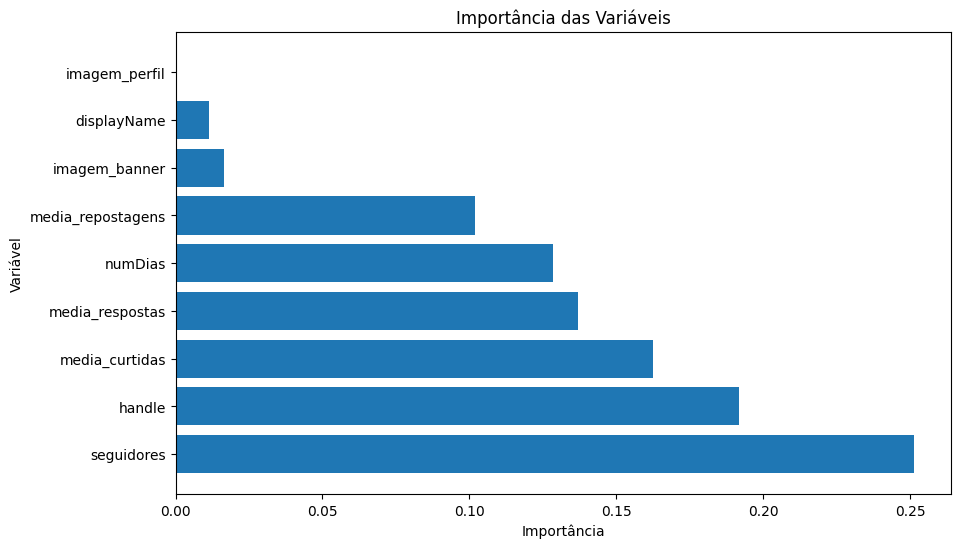

In [322]:
# Importância das Variáveis

importances = rf_model.feature_importances_
feature_names = x_treino.columns
df_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# Visualização
plt.figure(figsize=(10, 6))
plt.barh(df_importances['Feature'], df_importances['Importance'])
plt.xlabel('Importância')
plt.ylabel('Variável')
plt.title('Importância das Variáveis')
plt.show()


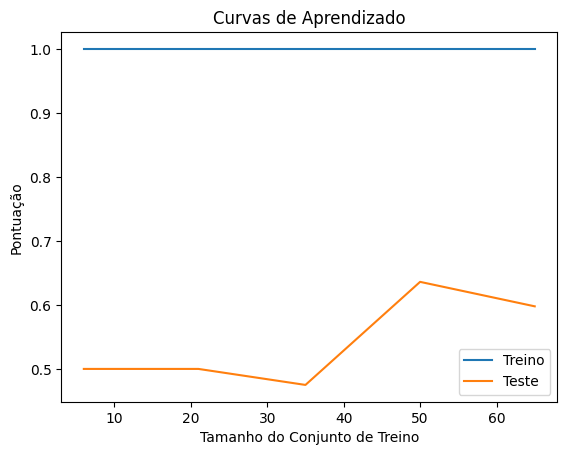

In [323]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(rf_model, x_treino, y_treino, cv=5)
plt.plot(train_sizes, train_scores.mean(axis=1), label='Treino')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Teste')
plt.legend()
plt.xlabel('Tamanho do Conjunto de Treino')
plt.ylabel('Pontuação')
plt.title('Curvas de Aprendizado')
plt.show()


### Naive Bayes

In [324]:
from sklearn.naive_bayes import ComplementNB

In [325]:
# Criar modelo.
model = ComplementNB()

In [326]:
# Treinar modelo.
model.fit(x_treino, y_treino)

ComplementNB()

In [327]:
# Fazer previsões
y_pred = model.predict(x_teste)

In [328]:
# Avaliar o desempenho.
print("Acurácia:", accuracy_score(y_teste, y_pred))
print("\nRelatório de Classificação:\n", classification_report(y_teste, y_pred))

Acurácia: 0.7933884297520661

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.85      0.92      0.88       104
           1       0.00      0.00      0.00        17

    accuracy                           0.79       121
   macro avg       0.42      0.46      0.44       121
weighted avg       0.73      0.79      0.76       121



### Árvore de decisão

In [329]:
from sklearn.tree import DecisionTreeClassifier

In [330]:
# Criar modelo.
model = DecisionTreeClassifier(random_state=0)

In [331]:
# Treinar modelo.
model.fit(x_treino, y_treino)

DecisionTreeClassifier(random_state=0)

In [332]:
# Fazer o modelo prever com base em x_teste.
y_pred = model.predict(x_teste)

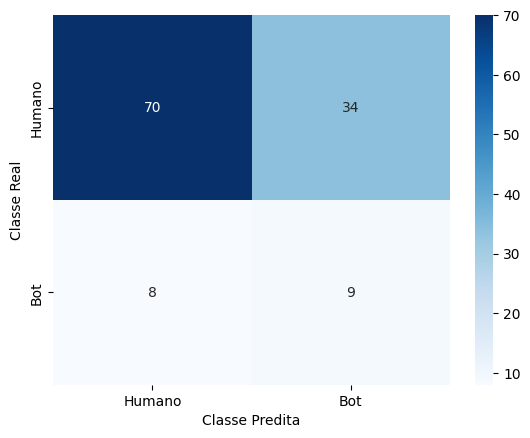

In [333]:
# Matriz de confusão.
from sklearn.metrics import confusion_matrix

# Matriz de confusão
cm = confusion_matrix(y_teste, y_pred)

import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Humano', 'Bot'], yticklabels=['Humano', 'Bot'])
plt.ylabel('Classe Real')
plt.xlabel('Classe Predita')
plt.show()

In [334]:
# Calcular acurácia.
accuracy = accuracy_score(y_teste, y_pred)
accuracy

0.6528925619834711

In [335]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calcular precisão, recall e F1-score
precision = precision_score(y_teste, y_pred)
recall = recall_score(y_teste, y_pred)
f1 = f1_score(y_teste, y_pred)

# capacidade do modelo de não classificar erroneamente exemplos humanos como bots.
# classifica muitos humanos como bots.
print(f'Precisão: {precision:.2f}')

# capacidade do modelo de encontrar todos os bots.
print(f'Recall: {recall:.2f}')

# o mais útil.
print(f'F1-Score: {f1:.2f}')

Precisão: 0.21
Recall: 0.53
F1-Score: 0.30


Testando possibilidades.

In [336]:
from itertools import product

In [337]:
arvores = {}

possibilidades = {
    "altura": [1, 2, 3, 4, 5],
}

combinacoes = list(product(*possibilidades.values()))

for c in combinacoes:
  # Criar modelo.
  model = DecisionTreeClassifier(random_state=0, max_depth=c[0])
  # Treinar modelo.
  model.fit(x_treino, y_treino)
  # Fazer o modelo prever com base em x_teste.
  y_pred = model.predict(x_teste)
  # Calcular acurácia.
  accuracy = accuracy_score(y_teste, y_pred)
  # capacidade do modelo de não classificar erroneamente exemplos humanos como bots.
  # classifica muitos humanos como bots.
  precision = precision_score(y_teste, y_pred)
  # capacidade do modelo de encontrar todos os bots.
  recall = recall_score(y_teste, y_pred)
  # o mais útil.
  f1 = f1_score(y_teste, y_pred)
  arvores[f"Altura: {c[0]}"] = f"Acurácia: {accuracy:.2f}; precisão: {precision:.2f}; recall: {recall:.2f}; f1: {f1:.2f}"

In [338]:
arvores

{'Altura: 1': 'Acurácia: 0.79; precisão: 0.00; recall: 0.00; f1: 0.00',
 'Altura: 2': 'Acurácia: 0.79; precisão: 0.00; recall: 0.00; f1: 0.00',
 'Altura: 3': 'Acurácia: 0.58; precisão: 0.23; recall: 0.82; f1: 0.35',
 'Altura: 4': 'Acurácia: 0.60; precisão: 0.20; recall: 0.65; f1: 0.31',
 'Altura: 5': 'Acurácia: 0.73; precisão: 0.17; recall: 0.24; f1: 0.20'}

### Regressão Logística

In [339]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [340]:
# Criando o Modelo.
model = LogisticRegression()

In [341]:
# Treinando o modelo.
model.fit(x_treino, y_treino)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [342]:
# Fazer previsões.
y_pred = model.predict(x_teste)

In [343]:
# Avaliar o modelo
print("Acurácia:", accuracy_score(y_teste, y_pred))
print("Relatório de Classificação:\n", classification_report(y_teste, y_pred))

# precisão: 78%
# recall: 69%
# f1-score: 75%

Acurácia: 0.6859504132231405
Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.88      0.73      0.80       104
           1       0.20      0.41      0.27        17

    accuracy                           0.69       121
   macro avg       0.54      0.57      0.53       121
weighted avg       0.79      0.69      0.73       121



In [344]:
import pandas as pd
coef = pd.DataFrame({
    "Atributo": x_treino.columns,
    "Coeficiente": model.coef_[0]
}).sort_values(by="Coeficiente", ascending=False)
print(coef)

            Atributo  Coeficiente
1        displayName     0.225717
2      imagem_perfil     0.146386
6    media_respostas     0.006943
3      imagem_banner     0.003095
5         seguidores     0.000075
4            numDias    -0.003117
0             handle    -0.004006
7  media_repostagens    -0.017853
8     media_curtidas    -0.148240
